# Importing necessary libs :-

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2Tokenizer
import math

# Configuration Dictionary for GPT2 124M Model :-

In [2]:
GPT2_CONFIG_124M = {
    'vocab_size': 50257,      # Vocabulary size
    'n_positions': 1024,       # Maximum sequence length (context window)
    'n_embd': 768,            # Embedding dimension (hidden size)
    'n_layer': 12,            # Number of transformer blocks
    'n_head': 12,             # Number of attention heads
    'n_inner': 3072,          # Inner dimension of feed-forward network (4 * n_embd)
    'activation': 'gelu',     # Activation function
    'resid_pdrop': 0.1,       # Residual dropout probability
    'embd_pdrop': 0.1,        # Embedding dropout probability
    'attn_pdrop': 0.1,        # Attention dropout probability
    'layer_norm_epsilon': 1e-5  # Layer normalization epsilon
}

# Layer normalization class :-

In [3]:
class LayerNorm(nn.Module):
    def __init__(self, config):
      super().__init__()
      self.eps = config['layer_norm_epsilon']
      self.scale = nn.Parameter(torch.ones(config['n_embd']))
      self.shift = nn.Parameter(torch.zeros(config['n_embd']))

    def forward(self, x):
      mean = x.mean(dim=-1, keepdim=True)
      var = x.var(dim=-1, keepdim=True, unbiased=False)
      norm_x = (x - mean) / torch.sqrt(var + self.eps)
      return self.scale * norm_x + self.shift

# GELU activation class :-

In [4]:
class GELU(nn.Module):
  def __init__(self):
      super().__init__()

  def forward(self, x):
      return 0.5 * x * (1 + torch.tanh(
          torch.sqrt(torch.tensor(2.0 / torch.pi)) *
          (x + 0.044715 * torch.pow(x, 3))
      ))

# Feed forward neural network module :-

In [5]:
"""
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config['n_embd'], config['n_inner'])  # Expansion
        self.c_proj = nn.Linear(config['n_inner'], config['n_embd'])  # Projection back
        self.act = GELU()

    def forward(self, x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        return x

"""

class MLP(nn.Module):
    """
    Position-wise feed-forward network.
    Consists of two linear layers with GELU activation in between.
    """
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config['n_embd'], config['n_inner'])  # Expansion
        self.c_proj = nn.Linear(config['n_inner'], config['n_embd'])  # Projection back
        self.act = nn.GELU()

    def forward(self, x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        return x

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.cpp_extension import load_inline
import math
import os

# Set build directory for Colab compatibility
BUILD_DIR = '/tmp/torch_extensions'
os.makedirs(BUILD_DIR, exist_ok=True)

# ============================================================================
# CUDA KERNEL: Standalone GELU (test if this works first)
# ============================================================================

cuda_gelu_source = """
#include <torch/extension.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <math.h>

#define SQRT_2_PI 0.7978845608028654f
#define COEFF 0.044715f

__global__ void gelu_forward_kernel(
    const float* __restrict__ x,
    float* __restrict__ out,
    int size
) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < size) {
        float val = x[idx];
        float cube = val * val * val;
        float inner = SQRT_2_PI * (val + COEFF * cube);
        out[idx] = 0.5f * val * (1.0f + tanhf(inner));
    }
}

torch::Tensor gelu_forward_cuda(torch::Tensor x) {
    auto out = torch::empty_like(x);
    int size = x.numel();

    const int threads = 256;
    const int blocks = (size + threads - 1) / threads;

    gelu_forward_kernel<<<blocks, threads>>>(
        x.data_ptr<float>(),
        out.data_ptr<float>(),
        size
    );

    return out;
}
"""

cpp_gelu_source = """
torch::Tensor gelu_forward_cuda(torch::Tensor x);
"""

print("Compiling GELU CUDA kernel...")
try:
    gelu_cuda = load_inline(
        name='gelu_cuda',
        cpp_sources=cpp_gelu_source,
        cuda_sources=cuda_gelu_source,
        functions=['gelu_forward_cuda'],
        verbose=True,
        extra_cuda_cflags=['-O3', '--use_fast_math'],
        build_directory=BUILD_DIR,
        with_cuda=True
    )
    print("✓ GELU kernel compiled!")
    GELU_CUDA_AVAILABLE = True
except Exception as e:
    print(f"⚠ GELU kernel compilation failed: {e}")
    GELU_CUDA_AVAILABLE = False
    gelu_cuda = None

# ============================================================================
# Modified MLP Class (using separate GELU for now)
# ============================================================================

class MLP(nn.Module):
    """
    Position-wise feed-forward network.
    """
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config['n_embd'], config['n_inner'])
        self.c_proj = nn.Linear(config['n_inner'], config['n_embd'])

    def forward(self, x):
        x = self.c_fc(x)

        # Use custom GELU if available
        if GELU_CUDA_AVAILABLE and x.is_cuda and x.dtype == torch.float32:
            x = gelu_cuda.gelu_forward_cuda(x.contiguous())
        else:
            x = F.gelu(x)

        x = self.c_proj(x)
        return x

Compiling GELU CUDA kernel...
⚠ GELU kernel compilation failed: /tmp/torch_extensions/gelu_cuda.so: cannot open shared object file: No such file or directory


# Causal multi-head attention class :-

In [6]:
class CausalMultiHeadSelfAttention(nn.Module):
    """
    Multi-head causal self-attention mechanism.
    Causal means tokens can only attend to previous tokens (autoregressive).
    """
    def __init__(self, config):
        super().__init__()
        assert config['n_embd'] % config['n_head'] == 0

        # Linear layer for query, key, value projections
        self.W_query = nn.Linear(config['n_embd'], config['n_embd'])
        self.W_key = nn.Linear(config['n_embd'], config['n_embd'])
        self.W_value = nn.Linear(config['n_embd'], config['n_embd'])

        # Output projection
        self.c_proj = nn.Linear(config['n_embd'], config['n_embd'])

        # Dropout layers
        self.attn_dropout = nn.Dropout(config['attn_pdrop'])

        self.n_head = config['n_head']
        self.n_embd = config['n_embd']

        # Causal mask to ensure attention only flows backwards
        # This is a lower triangular matrix
        self.register_buffer(
            "bias",
            torch.tril(torch.ones(config['n_positions'], config['n_positions']))
            .view(1, 1, config['n_positions'], config['n_positions'])
        )

    def forward(self, x):
        B, T, C = x.size()  # Batch size, sequence length, embedding dimension

        # Calculate query, key, values for all heads in batch
        k = self.W_key(x)
        q = self.W_query(x)
        v = self.W_value(x)

        # Reshape to separate heads: (B, T, C) -> (B, n_head, T, head_size)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        # Compute attention scores: (B, n_head, T, head_size) x (B, n_head, head_size, T) -> (B, n_head, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))

        # Apply causal mask (prevent attending to future tokens)
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))

        # Normalize with softmax
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)

        # Apply attention to values: (B, n_head, T, T) x (B, n_head, T, head_size) -> (B, n_head, T, head_size)
        y = att @ v

        # Reassemble all head outputs side by side
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # Output projection and dropout
        y = self.c_proj(y)
        return y


# Transformer Block :-

In [7]:

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config)
        self.attn = CausalMultiHeadSelfAttention(config)
        self.ln_2 = LayerNorm(config)
        self.mlp = MLP(config)
        self.drop_shortcut = nn.Dropout(config["resid_pdrop"])

    def forward(self, x):
        shortcut = x
        x = self.ln_1(x)
        x = self.attn(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.ln_2(x)
        x = self.mlp(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x


# GPT2 Model :-

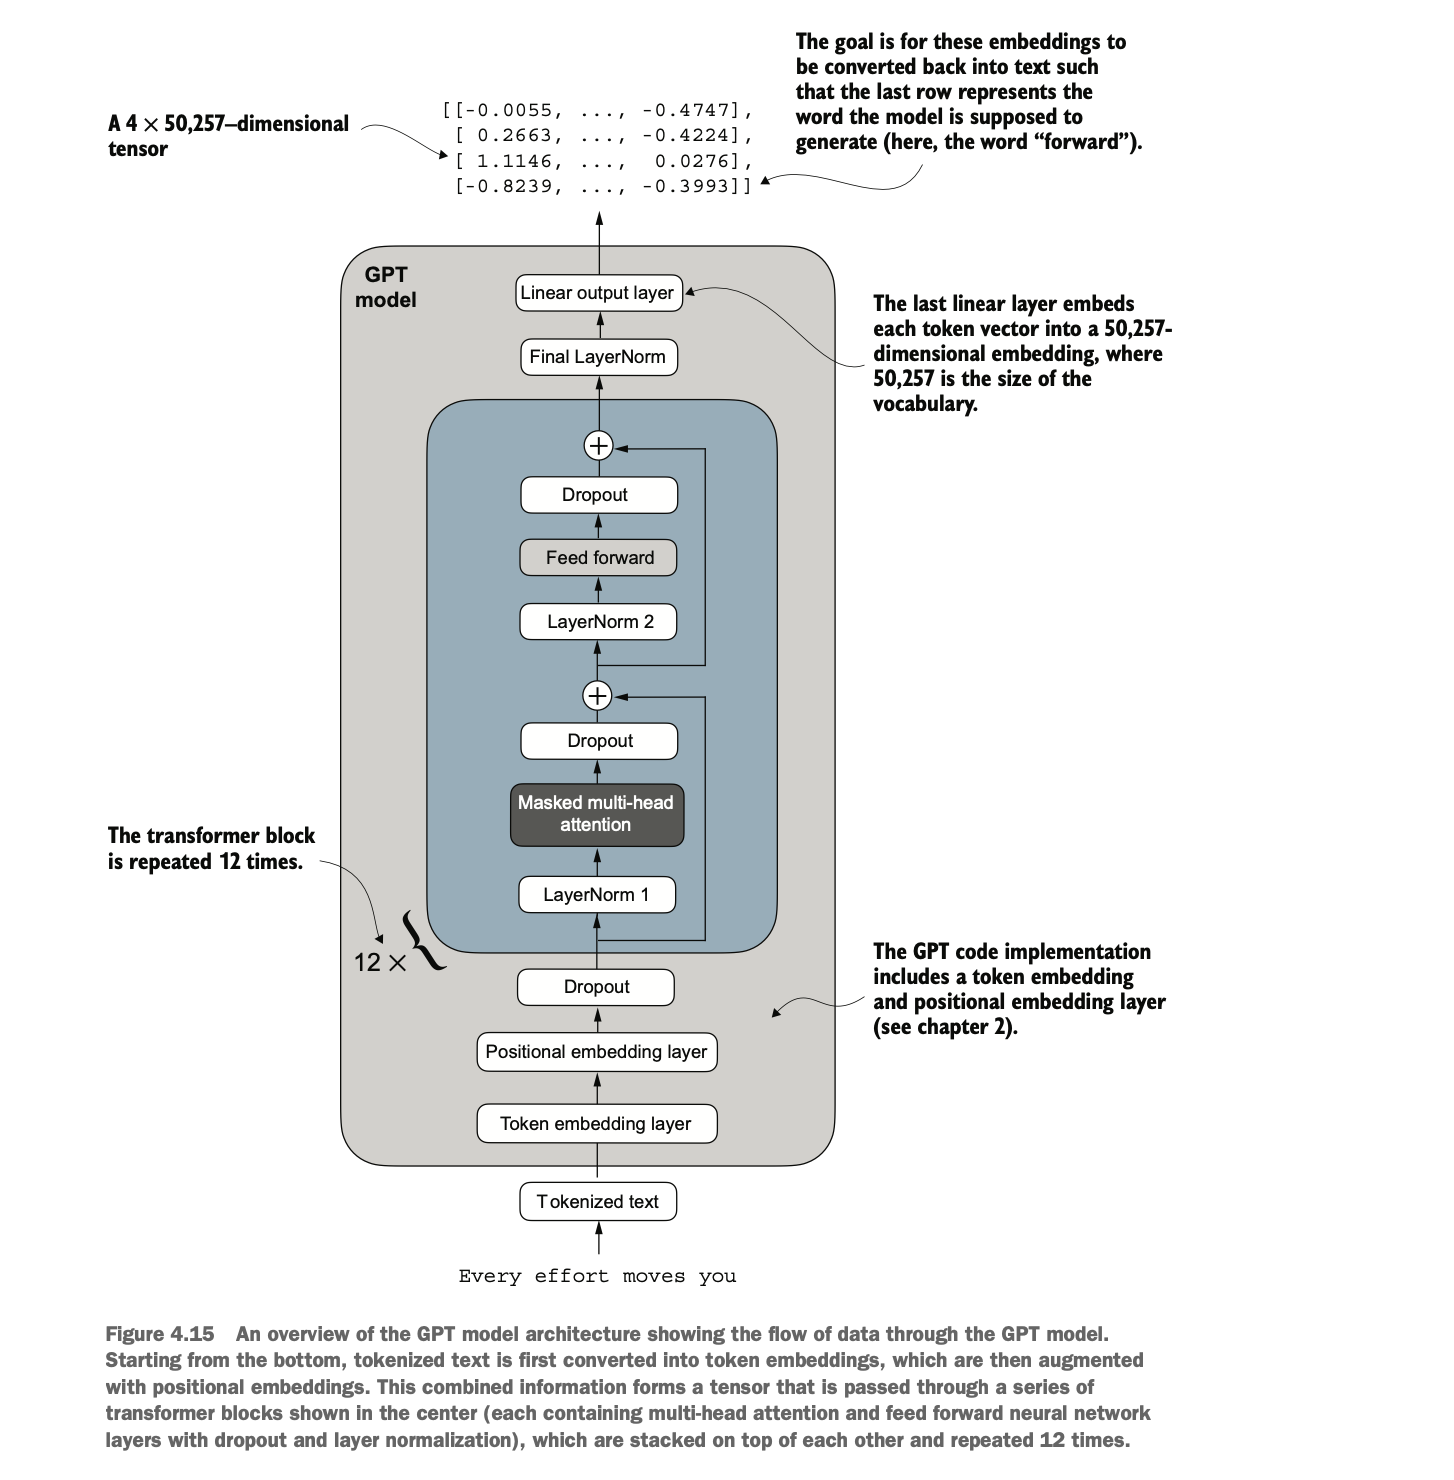


In [8]:
class GPT2(nn.Module):
    """
    Complete GPT-2 model implementation.
    """
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Token embeddings: maps token IDs to vectors
        self.wte = nn.Embedding(config['vocab_size'], config['n_embd'])

        # Position embeddings: maps positions to vectors
        self.wpe = nn.Embedding(config['n_positions'], config['n_embd'])

        # Embedding dropout
        self.drop = nn.Dropout(config['embd_pdrop'])

        # Stack of transformer blocks
        self.h = nn.ModuleList([Block(config) for _ in range(config['n_layer'])])

        # Final layer normalization
        self.ln_f = LayerNorm(config)

        # Language modeling head (projects back to vocabulary)
        # In GPT-2, this shares weights with token embeddings
        self.lm_head = nn.Linear(config['n_embd'], config['vocab_size'], bias=False)

        # Weight sharing: output projection uses same weights as input embeddings
        self.lm_head.weight = self.wte.weight


    def forward(self, idx):
        """
        Forward pass through the model.

        Args:
            idx: Input token IDs of shape (batch_size, sequence_length)
            targets: Target token IDs for training (optional)

        Returns:
            logits: Predicted logits of shape (batch_size, sequence_length, vocab_size)
            loss: Cross-entropy loss if targets are provided
        """
        device = idx.device
        b, t = idx.size()
        assert t <= self.config['n_positions'], f"Sequence length {t} exceeds max length {self.config['n_positions']}"

        # Get position indices
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)  # shape (1, t)

        # Token embeddings + position embeddings
        tok_emb = self.wte(idx)  # (b, t, n_embd)
        pos_emb = self.wpe(pos)  # (1, t, n_embd)
        x = self.drop(tok_emb + pos_emb)

        # Pass through all transformer blocks
        for block in self.h:
            x = block(x)

        # Final layer norm
        x = self.ln_f(x)

        # Project to vocabulary
        logits = self.lm_head(x)  # (b, t, vocab_size)

        return logits

# Load pretrained GPT-2 124M weights from HuggingFace into the custom model

In [9]:
def load_pretrained_weights(model):
    """
    Load pretrained GPT-2 124M weights from HuggingFace into the custom model.

    Args:
        model: Your custom GPT2 model instance
    """
    from transformers import GPT2LMHeadModel

    print("Loading pretrained GPT-2 124M weights from HuggingFace...")

    # Load the pretrained HuggingFace model
    hf_model = GPT2LMHeadModel.from_pretrained('gpt2')
    hf_state_dict = hf_model.state_dict()

    # Get your model's state dict
    custom_state_dict = model.state_dict()

    # Simple direct mappings (no transpose needed)
    simple_mappings = {
        # Token embeddings
        'transformer.wte.weight': 'wte.weight',

        # Position embeddings
        'transformer.wpe.weight': 'wpe.weight',

        # Final layer norm
        'transformer.ln_f.weight': 'ln_f.scale',
        'transformer.ln_f.bias': 'ln_f.shift',
    }

    # Load simple mappings
    for hf_name, custom_name in simple_mappings.items():
        if hf_name in hf_state_dict and custom_name in custom_state_dict:
            custom_state_dict[custom_name].copy_(hf_state_dict[hf_name])

    # Load each transformer block
    for i in range(model.config['n_layer']):
        # Layer norm 1
        custom_state_dict[f'h.{i}.ln_1.scale'].copy_(hf_state_dict[f'transformer.h.{i}.ln_1.weight'])
        custom_state_dict[f'h.{i}.ln_1.shift'].copy_(hf_state_dict[f'transformer.h.{i}.ln_1.bias'])

        # Attention QKV - split the combined c_attn
        c_attn_weight = hf_state_dict[f'transformer.h.{i}.attn.c_attn.weight']
        c_attn_bias = hf_state_dict[f'transformer.h.{i}.attn.c_attn.bias']

        n_embd = model.config['n_embd']

        # HuggingFace stores weights as (n_embd, 3*n_embd) - need to split along dim 1
        q_weight, k_weight, v_weight = c_attn_weight.split(n_embd, dim=1)
        q_bias, k_bias, v_bias = c_attn_bias.split(n_embd, dim=0)

        # Copy Q, K, V weights (transpose because HF format is transposed)
        custom_state_dict[f'h.{i}.attn.W_query.weight'].copy_(q_weight.T)
        custom_state_dict[f'h.{i}.attn.W_query.bias'].copy_(q_bias)

        custom_state_dict[f'h.{i}.attn.W_key.weight'].copy_(k_weight.T)
        custom_state_dict[f'h.{i}.attn.W_key.bias'].copy_(k_bias)

        custom_state_dict[f'h.{i}.attn.W_value.weight'].copy_(v_weight.T)
        custom_state_dict[f'h.{i}.attn.W_value.bias'].copy_(v_bias)

        # Attention output projection (transpose)
        custom_state_dict[f'h.{i}.attn.c_proj.weight'].copy_(
            hf_state_dict[f'transformer.h.{i}.attn.c_proj.weight'].T
        )
        custom_state_dict[f'h.{i}.attn.c_proj.bias'].copy_(
            hf_state_dict[f'transformer.h.{i}.attn.c_proj.bias']
        )

        # Layer norm 2
        custom_state_dict[f'h.{i}.ln_2.scale'].copy_(hf_state_dict[f'transformer.h.{i}.ln_2.weight'])
        custom_state_dict[f'h.{i}.ln_2.shift'].copy_(hf_state_dict[f'transformer.h.{i}.ln_2.bias'])

        # MLP - c_fc (transpose)
        custom_state_dict[f'h.{i}.mlp.c_fc.weight'].copy_(
            hf_state_dict[f'transformer.h.{i}.mlp.c_fc.weight'].T
        )
        custom_state_dict[f'h.{i}.mlp.c_fc.bias'].copy_(
            hf_state_dict[f'transformer.h.{i}.mlp.c_fc.bias']
        )

        # MLP - c_proj (transpose)
        custom_state_dict[f'h.{i}.mlp.c_proj.weight'].copy_(
            hf_state_dict[f'transformer.h.{i}.mlp.c_proj.weight'].T
        )
        custom_state_dict[f'h.{i}.mlp.c_proj.bias'].copy_(
            hf_state_dict[f'transformer.h.{i}.mlp.c_proj.bias']
        )

    print("✓ Pretrained weights loaded successfully!")

    # Verify weight sharing between wte and lm_head
    assert model.wte.weight.data_ptr() == model.lm_head.weight.data_ptr(), \
        "Weight sharing broken between wte and lm_head"

    return model

In [10]:
# Create your model
model = GPT2(GPT2_CONFIG_124M)

# Load pretrained weights
model = load_pretrained_weights(model)

# Now you can use the model for inference or fine-tuning
model.eval()

Loading pretrained GPT-2 124M weights from HuggingFace...


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

✓ Pretrained weights loaded successfully!


GPT2(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x Block(
      (ln_1): LayerNorm()
      (attn): CausalMultiHeadSelfAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (c_proj): Linear(in_features=768, out_features=768, bias=True)
        (attn_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm()
      (mlp): MLP(
        (c_fc): Linear(in_features=768, out_features=3072, bias=True)
        (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        (act): GELU(approximate='none')
      )
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
  )
  (ln_f): LayerNorm()
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

# Run Inference :-

In [24]:
def run_inference(model, tokenizer, prompt, max_new_tokens=50, temperature=0.8, top_k=50):
    """
    Run inference on a text prompt.

    Args:
        model: GPT-2 model
        tokenizer: Tokenizer
        prompt: Input text
        max_new_tokens: Number of tokens to generate
        temperature: Sampling temperature (higher = more random, lower = more deterministic)
        top_k: Top-k sampling parameter (only sample from top k most likely tokens)

    Returns:
        Generated text
    """
    model.eval()  # Set model to evaluation mode
    device = next(model.parameters()).device  # Get model's device

    # Encode the prompt
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

    # Store original length to know where generation starts
    original_length = input_ids.shape[1]

    print(f"Prompt: {prompt}")
    print(f"Generating {max_new_tokens} tokens...\n")

    # Generation loop
    with torch.no_grad():
        for _ in range(max_new_tokens):
            # Check if we've exceeded max context length
            if input_ids.shape[1] >= model.config['n_positions']:
                print("Warning: Reached maximum context length")
                break

            # Forward pass
            logits = model(input_ids)  # Shape: (batch_size, seq_len, vocab_size)

            # Get logits for the last token
            logits = logits[:, -1, :]  # Shape: (batch_size, vocab_size)

            # Apply temperature scaling
            logits = logits / temperature

            # Apply top-k filtering
            if top_k > 0:
                # Get top-k logits and indices
                top_k_logits, top_k_indices = torch.topk(logits, min(top_k, logits.size(-1)))

                # Create a mask for top-k tokens
                logits_filtered = torch.full_like(logits, float('-inf'))
                logits_filtered.scatter_(1, top_k_indices, top_k_logits)
                logits = logits_filtered

            # Convert logits to probabilities
            probs = F.softmax(logits, dim=-1)

            # Sample from the distribution
            next_token = torch.multinomial(probs, num_samples=1)

            # Append to the sequence
            input_ids = torch.cat([input_ids, next_token], dim=1)

            # Optional: Stop if we generate an end-of-text token
            if next_token.item() == tokenizer.eos_token_id:
                break

    # Decode the generated sequence
    generated_text = tokenizer.decode(input_ids[0], skip_special_tokens=True)

    return generated_text

In [25]:
# Load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Create and load model
model = GPT2(GPT2_CONFIG_124M)
model = load_pretrained_weights(model)
model.eval()

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Run inference
prompt = "My name is SHubham Ojha"
generated_text = run_inference(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_new_tokens=100,
    temperature=0.8,
    top_k=50
)

print("Generated Text:")
print(generated_text)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loading pretrained GPT-2 124M weights from HuggingFace...
✓ Pretrained weights loaded successfully!
Prompt: My name is SHubham Ojha
Generating 100 tokens...

Generated Text:
My name is SHubham Ojha, I am a mother of three and I am responsible for six children. I own and run my own business through a small office in a small town in south-west of Bangkok. So I am a very open-minded person.

I have worked for many years in the financial services industry, then I switched from banking to financial services for many years and there I am now in my twenties. I am an avid gambler and have been the last person to lose money in my life.


In [35]:
prompt = "What is your name?"
generated_text = run_inference(
    model=model,
    tokenizer=tokenizer,
    prompt=prompt,
    max_new_tokens=100,
    temperature=0.8,
    top_k=50
)

print("Generated Text:")
print(generated_text)

Prompt: What is your name?
Generating 100 tokens...

Generated Text:
What is your name? (What is your name?)

Sidney: I'm Sidney Karpowitz. I'm the founder and CEO of the startup Dolly Parton. I'm also the founder and manager of the site I worked for and now this is our site.

What is your name? (What is your name?)

Sidney: I'm Sidney Karpowitz. I'm the founder and CEO of the startup Dolly Parton. I'm also the founder


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.profiler import profile, record_function, ProfilerActivity
from transformers import GPT2Tokenizer

# ============================================================================
#              KERNEL-LEVEL PROFILER FOR ATTENTION ONLY
# ============================================================================

class AttentionKernelProfiler:
    """
    Kernel-level profiler focused on Causal Multi-Head Self-Attention operations.
    Breaks down attention into: QKV projection, attention scores, softmax, dropout,
    attention application, and output projection.
    """
    def __init__(self):
        self.results = {}

    def profile_operation(self, name, operation_fn, warmup=10, runs=100):
        """
        Profile a specific operation with detailed kernel analysis.
        """
        print(f"\n{'='*80}")
        print(f"  Profiling: {name}")
        print(f"{'='*80}")

        # Warmup
        for _ in range(warmup):
            operation_fn()

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        # Profile with PyTorch Profiler
        with profile(
            activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
            record_shapes=True,
            with_stack=False,
            with_flops=True,
        ) as prof:
            with record_function(name):
                for _ in range(runs):
                    operation_fn()
                    if torch.cuda.is_available():
                        torch.cuda.synchronize()

        # Store results
        self.results[name] = prof

        # Print summary
        self._print_kernel_summary(name, prof)

        return prof

    def _print_kernel_summary(self, name, prof):
        """Print detailed kernel analysis."""
        print(f"\n📊 Kernel Summary for: {name}")
        print("="*80)

        events = prof.key_averages()

        # Filter CUDA kernels
        cuda_kernels = []
        for e in events:
            has_cuda_time = (
                hasattr(e, 'self_device_time_total') and e.self_device_time_total > 0 or
                hasattr(e, 'self_cuda_time_total') and e.self_cuda_time_total > 0 or
                'cuda' in e.key.lower()
            )
            if has_cuda_time:
                cuda_kernels.append(e)

        if not cuda_kernels:
            print("No CUDA kernels found. Showing all events...")
            print("\nTop Operations:")
            print(f"{'Operation':<50} {'Self Time (ms)':>15} {'Total Time (ms)':>15} {'Count':>10}")
            print("-"*90)
            for evt in sorted(events, key=lambda x: x.self_cpu_time_total, reverse=True)[:15]:
                self_time = evt.self_cpu_time_total if hasattr(evt, 'self_cpu_time_total') else 0
                total_time = evt.cpu_time_total if hasattr(evt, 'cpu_time_total') else 0
                print(f"{evt.key[:50]:<50} {self_time/1000:>15.3f} {total_time/1000:>15.3f} {evt.count:>10}")
            return

        # Sort by CUDA time
        def get_cuda_time(e):
            if hasattr(e, 'self_cuda_time_total'):
                return e.self_cuda_time_total
            elif hasattr(e, 'self_device_time_total'):
                return e.self_device_time_total
            return 0

        cuda_kernels.sort(key=get_cuda_time, reverse=True)

        # Print kernel breakdown
        print(f"\n{'Kernel Name':<60} {'Self Time (ms)':>14} {'Count':>8} {'Avg (μs)':>12}")
        print("-"*95)

        total_cuda_time = sum(get_cuda_time(k) for k in cuda_kernels)

        for kernel in cuda_kernels[:20]:  # Top 20 kernels
            cuda_time = get_cuda_time(kernel)
            avg_time = cuda_time / kernel.count if kernel.count > 0 else 0
            print(f"{kernel.key[:60]:<60} {cuda_time/1000:>14.3f} {kernel.count:>8} {avg_time:>12.3f}")

        print("-"*95)
        print(f"{'TOTAL CUDA TIME':<60} {total_cuda_time/1000:>14.3f}")
        print("="*80)

        # FLOPS analysis
        print(f"\n⚡ FLOPS Analysis for: {name}")
        print("="*80)

        flops_events = [e for e in events if hasattr(e, 'flops') and e.flops > 0]
        if flops_events:
            total_flops = sum(e.flops for e in flops_events)
            total_time_s = sum(get_cuda_time(e) for e in flops_events) / 1e6

            if total_time_s > 0:
                tflops = (total_flops / total_time_s) / 1e12
                print(f"Total FLOPs:     {total_flops/1e9:>10.3f} GFLOPs")
                print(f"Total Time:      {total_time_s*1000:>10.3f} ms")
                print(f"Achieved:        {tflops:>10.3f} TFLOP/s")
                print(f"\n(T4 Theoretical Peak: ~8.1 TFLOPS FP32, ~65 TFLOPS FP16)")
        else:
            print("No FLOPS data available")

        print("="*80 + "\n")

    def export_trace(self, name, filename=None):
        """Export Chrome trace for visualization."""
        if name not in self.results:
            print(f"No profiling data for {name}")
            return

        if filename is None:
            filename = f"{name.replace(' ', '_')}_trace.json"

        self.results[name].export_chrome_trace(filename)
        print(f"✓ Exported trace to: {filename}")
        print(f"  Open in Chrome: chrome://tracing\n")


# ============================================================================
#         ATTENTION OPERATION PROFILING FUNCTIONS
# ============================================================================

def profile_qkv_projection(model, sample_input, attn_profiler):
    """
    Profile Query, Key, Value projection layers.
    These are three separate linear transformations.
    """
    device = sample_input.device
    block = model.h[0]

    # Prepare input (after layer norm)
    with torch.no_grad():
        pos = torch.arange(0, sample_input.size(1), dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = model.wte(sample_input)
        pos_emb = model.wpe(pos)
        x = model.drop(tok_emb + pos_emb)
        x = block.ln_1(x)

    attn = block.attn

    def qkv_projection_op():
        with torch.no_grad():
            q = attn.W_query(x)
            k = attn.W_key(x)
            v = attn.W_value(x)
        return q, k, v

    prof = attn_profiler.profile_operation(
        "Attention_QKV_Projection",
        qkv_projection_op,
        warmup=10,
        runs=100
    )

    return prof


def profile_attention_scores(model, sample_input, attn_profiler):
    """
    Profile attention score computation: (Q @ K^T) / sqrt(d_k)
    This is the matrix multiplication followed by scaling.
    """
    device = sample_input.device
    block = model.h[0]
    B, T = sample_input.size()
    n_head = block.attn.n_head
    n_embd = block.attn.n_embd

    # Prepare input through QKV projection
    with torch.no_grad():
        pos = torch.arange(0, T, dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = model.wte(sample_input)
        pos_emb = model.wpe(pos)
        x = model.drop(tok_emb + pos_emb)
        x = block.ln_1(x)

        attn = block.attn
        q = attn.W_query(x)
        k = attn.W_key(x)

        # Reshape for multi-head: (B, T, n_embd) -> (B, n_head, T, head_size)
        q = q.view(B, T, n_head, n_embd // n_head).transpose(1, 2)
        k = k.view(B, T, n_head, n_embd // n_head).transpose(1, 2)

    def attention_scores_op():
        with torch.no_grad():
            # (B, n_head, T, head_size) x (B, n_head, head_size, T) -> (B, n_head, T, T)
            att = (q @ k.transpose(-2, -1)) * (1.0 / torch.sqrt(torch.tensor(k.size(-1), dtype=torch.float32, device=device)))
        return att

    prof = attn_profiler.profile_operation(
        "Attention_Score_Computation",
        attention_scores_op,
        warmup=10,
        runs=100
    )

    return prof


def profile_causal_mask_softmax(model, sample_input, attn_profiler):
    """
    Profile causal masking and softmax normalization.
    Includes: masked_fill operation and softmax computation.
    """
    device = sample_input.device
    block = model.h[0]
    B, T = sample_input.size()
    n_head = block.attn.n_head
    n_embd = block.attn.n_embd

    # Prepare attention scores
    with torch.no_grad():
        pos = torch.arange(0, T, dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = model.wte(sample_input)
        pos_emb = model.wpe(pos)
        x = model.drop(tok_emb + pos_emb)
        x = block.ln_1(x)

        attn = block.attn
        q = attn.W_query(x)
        k = attn.W_key(x)

        q = q.view(B, T, n_head, n_embd // n_head).transpose(1, 2)
        k = k.view(B, T, n_head, n_embd // n_head).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) * (1.0 / torch.sqrt(torch.tensor(k.size(-1), dtype=torch.float32, device=device)))

    def causal_mask_softmax_op():
        with torch.no_grad():
            # Apply causal mask
            att_masked = att.masked_fill(attn.bias[:, :, :T, :T] == 0, float('-inf'))
            # Apply softmax
            att_softmax = F.softmax(att_masked, dim=-1)
        return att_softmax

    prof = attn_profiler.profile_operation(
        "Attention_Causal_Mask_Softmax",
        causal_mask_softmax_op,
        warmup=10,
        runs=100
    )

    return prof


def profile_attention_dropout(model, sample_input, attn_profiler):
    """
    Profile attention dropout operation.
    """
    device = sample_input.device
    block = model.h[0]
    B, T = sample_input.size()
    n_head = block.attn.n_head
    n_embd = block.attn.n_embd

    # Prepare softmax attention weights
    with torch.no_grad():
        pos = torch.arange(0, T, dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = model.wte(sample_input)
        pos_emb = model.wpe(pos)
        x = model.drop(tok_emb + pos_emb)
        x = block.ln_1(x)

        attn = block.attn
        q = attn.W_query(x)
        k = attn.W_key(x)

        q = q.view(B, T, n_head, n_embd // n_head).transpose(1, 2)
        k = k.view(B, T, n_head, n_embd // n_head).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) * (1.0 / torch.sqrt(torch.tensor(k.size(-1), dtype=torch.float32, device=device)))
        att_masked = att.masked_fill(attn.bias[:, :, :T, :T] == 0, float('-inf'))
        att_softmax = F.softmax(att_masked, dim=-1)

    def attention_dropout_op():
        with torch.no_grad():
            att_dropout = attn.attn_dropout(att_softmax)
        return att_dropout

    prof = attn_profiler.profile_operation(
        "Attention_Dropout",
        attention_dropout_op,
        warmup=10,
        runs=100
    )

    return prof


def profile_attention_weighted_sum(model, sample_input, attn_profiler):
    """
    Profile weighted sum of values: Attention @ V
    This is the matrix multiplication of attention weights with values.
    """
    device = sample_input.device
    block = model.h[0]
    B, T = sample_input.size()
    n_head = block.attn.n_head
    n_embd = block.attn.n_embd

    # Prepare attention weights and values
    with torch.no_grad():
        pos = torch.arange(0, T, dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = model.wte(sample_input)
        pos_emb = model.wpe(pos)
        x = model.drop(tok_emb + pos_emb)
        x = block.ln_1(x)

        attn = block.attn
        q = attn.W_query(x)
        k = attn.W_key(x)
        v = attn.W_value(x)

        q = q.view(B, T, n_head, n_embd // n_head).transpose(1, 2)
        k = k.view(B, T, n_head, n_embd // n_head).transpose(1, 2)
        v = v.view(B, T, n_head, n_embd // n_head).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) * (1.0 / torch.sqrt(torch.tensor(k.size(-1), dtype=torch.float32, device=device)))
        att_masked = att.masked_fill(attn.bias[:, :, :T, :T] == 0, float('-inf'))
        att_softmax = F.softmax(att_masked, dim=-1)
        att_dropout = attn.attn_dropout(att_softmax)

    def attention_weighted_sum_op():
        with torch.no_grad():
            # (B, n_head, T, T) x (B, n_head, T, head_size) -> (B, n_head, T, head_size)
            y = att_dropout @ v
        return y

    prof = attn_profiler.profile_operation(
        "Attention_Weighted_Sum",
        attention_weighted_sum_op,
        warmup=10,
        runs=100
    )

    return prof


def profile_attention_output_projection(model, sample_input, attn_profiler):
    """
    Profile output projection: reshape and linear transformation.
    """
    device = sample_input.device
    block = model.h[0]
    B, T = sample_input.size()
    n_head = block.attn.n_head
    n_embd = block.attn.n_embd

    # Prepare attention output
    with torch.no_grad():
        pos = torch.arange(0, T, dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = model.wte(sample_input)
        pos_emb = model.wpe(pos)
        x = model.drop(tok_emb + pos_emb)
        x = block.ln_1(x)

        attn = block.attn
        q = attn.W_query(x)
        k = attn.W_key(x)
        v = attn.W_value(x)

        q = q.view(B, T, n_head, n_embd // n_head).transpose(1, 2)
        k = k.view(B, T, n_head, n_embd // n_head).transpose(1, 2)
        v = v.view(B, T, n_head, n_embd // n_head).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) * (1.0 / torch.sqrt(torch.tensor(k.size(-1), dtype=torch.float32, device=device)))
        att_masked = att.masked_fill(attn.bias[:, :, :T, :T] == 0, float('-inf'))
        att_softmax = F.softmax(att_masked, dim=-1)
        att_dropout = attn.attn_dropout(att_softmax)
        y = att_dropout @ v

    def output_projection_op():
        with torch.no_grad():
            # Reshape: (B, n_head, T, head_size) -> (B, T, n_embd)
            y_concat = y.transpose(1, 2).contiguous().view(B, T, n_embd)
            # Linear projection
            y_proj = attn.c_proj(y_concat)
        return y_proj

    prof = attn_profiler.profile_operation(
        "Attention_Output_Projection",
        output_projection_op,
        warmup=10,
        runs=100
    )

    return prof


def profile_full_attention(model, sample_input, attn_profiler):
    """
    Profile complete attention mechanism end-to-end.
    This shows the combined cost of all operations together.
    """
    device = sample_input.device
    block = model.h[0]

    # Prepare input (after layer norm)
    with torch.no_grad():
        pos = torch.arange(0, sample_input.size(1), dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = model.wte(sample_input)
        pos_emb = model.wpe(pos)
        x = model.drop(tok_emb + pos_emb)
        x = block.ln_1(x)

    attn = block.attn

    def full_attention_op():
        with torch.no_grad():
            y = attn(x)
        return y

    prof = attn_profiler.profile_operation(
        "Attention_Full_Pipeline",
        full_attention_op,
        warmup=10,
        runs=100
    )

    return prof


# ============================================================================
#                   MAIN ATTENTION PROFILING
# ============================================================================

def run_attention_kernel_profiling(model, tokenizer, prompt="My name is Shubham Ojha",
                                   export_traces=True):
    """
    Run complete kernel profiling on Attention operations.
    """
    model.eval()
    device = next(model.parameters()).device

    print("\n" + "="*80)
    print("  GPT-2 KERNEL-LEVEL PROFILING: CAUSAL MULTI-HEAD SELF-ATTENTION")
    print("="*80)
    print(f"Device: {device}")
    print(f"PyTorch Version: {torch.__version__}")
    print(f"CUDA Available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA Version: {torch.version.cuda}")
        print(f"GPU: {torch.cuda.get_device_name(0)}")
    print("="*80 + "\n")

    # Prepare sample input
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

    # Initialize profiler
    attn_profiler = AttentionKernelProfiler()

    # Profile attention operations individually
    print("\n🎯 PROFILING: QKV Projection (Query, Key, Value)")
    prof1 = profile_qkv_projection(model, input_ids, attn_profiler)
    if export_traces:
        attn_profiler.export_trace("Attention_QKV_Projection", "attn_qkv_projection_trace.json")

    print("\n🎯 PROFILING: Attention Score Computation (Q @ K^T / sqrt(d_k))")
    prof2 = profile_attention_scores(model, input_ids, attn_profiler)
    if export_traces:
        attn_profiler.export_trace("Attention_Score_Computation", "attn_score_computation_trace.json")

    print("\n🎯 PROFILING: Causal Mask & Softmax")
    prof3 = profile_causal_mask_softmax(model, input_ids, attn_profiler)
    if export_traces:
        attn_profiler.export_trace("Attention_Causal_Mask_Softmax", "attn_causal_mask_softmax_trace.json")

    print("\n🎯 PROFILING: Attention Dropout")
    prof4 = profile_attention_dropout(model, input_ids, attn_profiler)
    if export_traces:
        attn_profiler.export_trace("Attention_Dropout", "attn_dropout_trace.json")

    print("\n🎯 PROFILING: Attention Weighted Sum (Att @ V)")
    prof5 = profile_attention_weighted_sum(model, input_ids, attn_profiler)
    if export_traces:
        attn_profiler.export_trace("Attention_Weighted_Sum", "attn_weighted_sum_trace.json")

    print("\n🎯 PROFILING: Output Projection & Reshape")
    prof6 = profile_attention_output_projection(model, input_ids, attn_profiler)
    if export_traces:
        attn_profiler.export_trace("Attention_Output_Projection", "attn_output_projection_trace.json")

    print("\n🎯 PROFILING: Full Attention Pipeline (End-to-End)")
    prof7 = profile_full_attention(model, input_ids, attn_profiler)
    if export_traces:
        attn_profiler.export_trace("Attention_Full_Pipeline", "attn_full_pipeline_trace.json")

    print("\n" + "="*80)
    print("  ✅ ATTENTION KERNEL PROFILING COMPLETE!")
    print("="*80)

    if export_traces:
        print("\n📁 Chrome traces exported:")
        print("  - attn_qkv_projection_trace.json")
        print("  - attn_score_computation_trace.json")
        print("  - attn_causal_mask_softmax_trace.json")
        print("  - attn_dropout_trace.json")
        print("  - attn_weighted_sum_trace.json")
        print("  - attn_output_projection_trace.json")
        print("  - attn_full_pipeline_trace.json")
        print("\nTo view:")
        print("  1. Open Chrome browser")
        print("  2. Navigate to: chrome://tracing")
        print("  3. Click 'Load' and select any .json file")
        print("="*80 + "\n")

    return attn_profiler


# ============================================================================
#                              MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":

    print("Loading model and tokenizer...")
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Import GPT2 and config from your model code
    # from GPT2_124M_model_code import GPT2, GPT2_CONFIG_124M
    # For now, assuming they're available in scope

    # Create and load model
    model = GPT2(GPT2_CONFIG_124M)
    model = load_pretrained_weights(model)
    model.eval()

    # Move to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    if device.type == 'cpu':
        print("\n⚠️  WARNING: Running on CPU. GPU kernels will not be captured.\n")

    # Run attention kernel profiling
    attn_profiler = run_attention_kernel_profiling(
        model=model,
        tokenizer=tokenizer,
        prompt="My name is Shubham Ojha",
        export_traces=True
    )

Loading model and tokenizer...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loading pretrained GPT-2 124M weights from HuggingFace...
✓ Pretrained weights loaded successfully!

  GPT-2 KERNEL-LEVEL PROFILING: CAUSAL MULTI-HEAD SELF-ATTENTION
Device: cuda:0
PyTorch Version: 2.9.0+cu126
CUDA Available: True
CUDA Version: 12.6
GPU: Tesla T4


🎯 PROFILING: QKV Projection (Query, Key, Value)

  Profiling: Attention_QKV_Projection

📊 Kernel Summary for: Attention_QKV_Projection

Kernel Name                                                  Self Time (ms)    Count     Avg (μs)
-----------------------------------------------------------------------------------------------
Attention_QKV_Projection                                             46.044        1    46044.153
aten::addmm                                                          12.727      300       42.423
void gemmSN_TN_kernel<float, 128, 16, 2, 4, 10, 11, false, c         12.727      300       42.423
Unrecognized                                                          0.043        1       43.200
cudaLaunchKe

In [12]:
ls

attn_causal_mask_softmax_trace.json  attn_qkv_projection_trace.json
attn_dropout_trace.json              attn_score_computation_trace.json
attn_full_pipeline_trace.json        attn_weighted_sum_trace.json
attn_output_projection_trace.json    sample_data/


In [12]:
import torch
import torch.nn.functional as F
from torch.profiler import profile, record_function, ProfilerActivity
from transformers import GPT2Tokenizer

# ============================================================================
#                    KERNEL-LEVEL PROFILER FOR MLP ONLY
# ============================================================================

class KernelProfiler:
    """
    Kernel-level profiler focused on MLP operations only.
    """
    def __init__(self):
        self.results = {}

    def profile_operation(self, name, operation_fn, warmup=10, runs=100):
        """
        Profile a specific operation with detailed kernel analysis.
        """
        print(f"\n{'='*80}")
        print(f"  Profiling: {name}")
        print(f"{'='*80}")

        # Warmup
        for _ in range(warmup):
            operation_fn()

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        # Profile with PyTorch Profiler
        with profile(
            activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
            record_shapes=True,
            with_stack=False,
            with_flops=True,
        ) as prof:
            with record_function(name):
                for _ in range(runs):
                    operation_fn()
                    if torch.cuda.is_available():
                        torch.cuda.synchronize()

        # Store results
        self.results[name] = prof

        # Print summary
        self._print_kernel_summary(name, prof)

        return prof

    def _print_kernel_summary(self, name, prof):
        """Print detailed kernel analysis."""
        print(f"\n📊 Kernel Summary for: {name}")
        print("="*80)

        events = prof.key_averages()

        # Filter CUDA kernels
        cuda_kernels = []
        for e in events:
            has_cuda_time = (
                hasattr(e, 'self_device_time_total') and e.self_device_time_total > 0 or
                hasattr(e, 'self_cuda_time_total') and e.self_cuda_time_total > 0 or
                'cuda' in e.key.lower()
            )
            if has_cuda_time:
                cuda_kernels.append(e)

        if not cuda_kernels:
            print("No CUDA kernels found. Showing all events...")
            print("\nTop Operations:")
            print(f"{'Operation':<50} {'Self Time (ms)':>15} {'Total Time (ms)':>15} {'Count':>10}")
            print("-"*90)
            for evt in sorted(events, key=lambda x: x.self_cpu_time_total, reverse=True)[:15]:
                self_time = evt.self_cpu_time_total if hasattr(evt, 'self_cpu_time_total') else 0
                total_time = evt.cpu_time_total if hasattr(evt, 'cpu_time_total') else 0
                print(f"{evt.key[:50]:<50} {self_time/1000:>15.3f} {total_time/1000:>15.3f} {evt.count:>10}")
            return

        # Sort by CUDA time
        def get_cuda_time(e):
            if hasattr(e, 'self_cuda_time_total'):
                return e.self_cuda_time_total
            elif hasattr(e, 'self_device_time_total'):
                return e.self_device_time_total
            return 0

        cuda_kernels.sort(key=get_cuda_time, reverse=True)

        # Print kernel breakdown
        print(f"\n{'Kernel Name':<60} {'Self Time (ms)':>14} {'Count':>8} {'Avg (μs)':>12}")
        print("-"*95)

        total_cuda_time = sum(get_cuda_time(k) for k in cuda_kernels)

        for kernel in cuda_kernels[:20]:  # Top 20 kernels
            cuda_time = get_cuda_time(kernel)
            avg_time = cuda_time / kernel.count if kernel.count > 0 else 0
            print(f"{kernel.key[:60]:<60} {cuda_time/1000:>14.3f} {kernel.count:>8} {avg_time:>12.3f}")

        print("-"*95)
        print(f"{'TOTAL CUDA TIME':<60} {total_cuda_time/1000:>14.3f}")
        print("="*80)

        # FLOPS analysis
        print(f"\n⚡ FLOPS Analysis for: {name}")
        print("="*80)

        flops_events = [e for e in events if hasattr(e, 'flops') and e.flops > 0]
        if flops_events:
            total_flops = sum(e.flops for e in flops_events)
            total_time_s = sum(get_cuda_time(e) for e in flops_events) / 1e6

            if total_time_s > 0:
                tflops = (total_flops / total_time_s) / 1e12
                print(f"Total FLOPs:     {total_flops/1e9:>10.3f} GFLOPs")
                print(f"Total Time:      {total_time_s*1000:>10.3f} ms")
                print(f"Achieved:        {tflops:>10.3f} TFLOP/s")
                print(f"\n(T4 Theoretical Peak: ~8.1 TFLOPS FP32, ~65 TFLOPS FP16)")
        else:
            print("No FLOPS data available")

        print("="*80 + "\n")

    def export_trace(self, name, filename=None):
        """Export Chrome trace for visualization."""
        if name not in self.results:
            print(f"No profiling data for {name}")
            return

        if filename is None:
            filename = f"{name.replace(' ', '_')}_trace.json"

        self.results[name].export_chrome_trace(filename)
        print(f"✓ Exported trace to: {filename}")
        print(f"  Open in Chrome: chrome://tracing\n")


# ============================================================================
#              MLP OPERATION PROFILING FUNCTIONS
# ============================================================================

def profile_mlp_expansion(model, sample_input, kernel_profiler):
    """
    Profile MLP expansion layer only.
    """
    device = sample_input.device
    block = model.h[0]

    # Prepare input (after attention, at MLP input)
    with torch.no_grad():
        pos = torch.arange(0, sample_input.size(1), dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = model.wte(sample_input)
        pos_emb = model.wpe(pos)
        x = model.drop(tok_emb + pos_emb)

        # Through attention
        shortcut = x
        x = block.ln_1(x)
        x = block.attn(x)
        x = block.drop_shortcut(x)
        x = x + shortcut

        # To MLP input
        x = block.ln_2(x)

    mlp = block.mlp

    def mlp_expansion_op():
        with torch.no_grad():
            x_exp = mlp.c_fc(x)
        return x_exp

    prof = kernel_profiler.profile_operation(
        "MLP_Expansion",
        mlp_expansion_op,
        warmup=10,
        runs=100
    )

    return prof


def profile_mlp_activation(model, sample_input, kernel_profiler):
    """
    Profile MLP GELU activation only.
    """
    device = sample_input.device
    block = model.h[0]

    # Prepare input (after expansion)
    with torch.no_grad():
        pos = torch.arange(0, sample_input.size(1), dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = model.wte(sample_input)
        pos_emb = model.wpe(pos)
        x = model.drop(tok_emb + pos_emb)

        # Through attention
        shortcut = x
        x = block.ln_1(x)
        x = block.attn(x)
        x = block.drop_shortcut(x)
        x = x + shortcut

        # Through MLP expansion
        x = block.ln_2(x)
        x = block.mlp.c_fc(x)

    mlp = block.mlp

    def mlp_activation_op():
        with torch.no_grad():
            # Apply PyTorch GELU activation
            x_act = F.gelu(x)
        return x_act

    prof = kernel_profiler.profile_operation(
        "MLP_Activation_GELU",
        mlp_activation_op,
        warmup=10,
        runs=100
    )

    return prof


def profile_mlp_projection(model, sample_input, kernel_profiler):
    """
    Profile MLP projection layer only.
    """
    device = sample_input.device
    block = model.h[0]

    # Prepare input (after activation)
    with torch.no_grad():
        pos = torch.arange(0, sample_input.size(1), dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = model.wte(sample_input)
        pos_emb = model.wpe(pos)
        x = model.drop(tok_emb + pos_emb)

        # Through attention
        shortcut = x
        x = block.ln_1(x)
        x = block.attn(x)
        x = block.drop_shortcut(x)
        x = x + shortcut

        # Through MLP expansion + activation
        x = block.ln_2(x)
        x = block.mlp.c_fc(x)
        # PyTorch GELU activation
        x = F.gelu(x)

    mlp = block.mlp

    def mlp_projection_op():
        with torch.no_grad():
            x_proj = mlp.c_proj(x)
        return x_proj

    prof = kernel_profiler.profile_operation(
        "MLP_Projection",
        mlp_projection_op,
        warmup=10,
        runs=100
    )

    return prof


def profile_mlp_fused(model, sample_input, kernel_profiler):
    """
    Profile entire MLP pipeline (Expansion -> GELU -> Projection).
    This shows what happens when all three are executed together.
    """
    device = sample_input.device
    block = model.h[0]

    # Prepare input
    with torch.no_grad():
        pos = torch.arange(0, sample_input.size(1), dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = model.wte(sample_input)
        pos_emb = model.wpe(pos)
        x = model.drop(tok_emb + pos_emb)

        # Through attention
        shortcut = x
        x = block.ln_1(x)
        x = block.attn(x)
        x = block.drop_shortcut(x)
        x = x + shortcut

        # To MLP input
        x = block.ln_2(x)

    mlp = block.mlp

    def mlp_fused_op():
        with torch.no_grad():
            x_exp = mlp.c_fc(x)
            # PyTorch GELU activation
            x_act = F.gelu(x_exp)
            x_proj = mlp.c_proj(x_act)
        return x_proj

    prof = kernel_profiler.profile_operation(
        "MLP_Full_Pipeline",
        mlp_fused_op,
        warmup=10,
        runs=100
    )

    return prof


# ============================================================================
#                        MAIN MLP PROFILING
# ============================================================================

def run_mlp_kernel_profiling(model, tokenizer, prompt="My name is Shubham Ojha",
                             export_traces=True):
    """
    Run complete kernel profiling on MLP operations only.
    """
    model.eval()
    device = next(model.parameters()).device

    print("\n" + "="*80)
    print("  GPT-2 KERNEL-LEVEL PROFILING: MLP ONLY")
    print("="*80)
    print(f"Device: {device}")
    print(f"PyTorch Version: {torch.__version__}")
    print(f"CUDA Available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA Version: {torch.version.cuda}")
        print(f"GPU: {torch.cuda.get_device_name(0)}")
    print("="*80 + "\n")

    # Prepare sample input
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

    # Initialize kernel profiler
    kernel_profiler = KernelProfiler()

    # Profile MLP operations individually
    print("\n🎯 PROFILING: MLP Expansion Layer")
    prof1 = profile_mlp_expansion(model, input_ids, kernel_profiler)
    if export_traces:
        kernel_profiler.export_trace("MLP_Expansion", "mlp_expansion_trace.json")

    print("\n🎯 PROFILING: MLP GELU Activation")
    prof2 = profile_mlp_activation(model, input_ids, kernel_profiler)
    if export_traces:
        kernel_profiler.export_trace("MLP_Activation_GELU", "mlp_activation_trace.json")

    print("\n🎯 PROFILING: MLP Projection Layer")
    prof3 = profile_mlp_projection(model, input_ids, kernel_profiler)
    if export_traces:
        kernel_profiler.export_trace("MLP_Projection", "mlp_projection_trace.json")

    print("\n🎯 PROFILING: Full MLP Pipeline (Expansion->GELU->Projection)")
    prof4 = profile_mlp_fused(model, input_ids, kernel_profiler)
    if export_traces:
        kernel_profiler.export_trace("MLP_Full_Pipeline", "mlp_full_pipeline_trace.json")

    print("\n" + "="*80)
    print("  ✅ MLP KERNEL PROFILING COMPLETE!")
    print("="*80)

    if export_traces:
        print("\n📁 Chrome traces exported:")
        print("  - mlp_expansion_trace.json")
        print("  - mlp_activation_trace.json")
        print("  - mlp_projection_trace.json")
        print("  - mlp_full_pipeline_trace.json")
        print("\nTo view:")
        print("  1. Open Chrome browser")
        print("  2. Navigate to: chrome://tracing")
        print("  3. Click 'Load' and select any .json file")
        print("="*80 + "\n")

    return kernel_profiler


# ============================================================================
#                              MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":


    print("Loading model and tokenizer...")
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Create and load model
    model = GPT2(GPT2_CONFIG_124M)
    model = load_pretrained_weights(model)
    model.eval()

    # Move to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    if device.type == 'cpu':
        print("\n⚠️  WARNING: Running on CPU. GPU kernels will not be captured.\n")

    # Run MLP kernel profiling
    kernel_profiler = run_mlp_kernel_profiling(
        model=model,
        tokenizer=tokenizer,
        prompt="My name is Shubham Ojha",
        export_traces=True
    )

Loading model and tokenizer...
Loading pretrained GPT-2 124M weights from HuggingFace...
✓ Pretrained weights loaded successfully!

  GPT-2 KERNEL-LEVEL PROFILING: MLP ONLY
Device: cuda:0
PyTorch Version: 2.9.0+cu126
CUDA Available: True
CUDA Version: 12.6
GPU: Tesla T4


🎯 PROFILING: MLP Expansion Layer

  Profiling: MLP_Expansion

📊 Kernel Summary for: MLP_Expansion

Kernel Name                                                  Self Time (ms)    Count     Avg (μs)
-----------------------------------------------------------------------------------------------
MLP_Expansion                                                        14.943        1    14942.852
aten::addmm                                                           9.576      100       95.759
volta_sgemm_128x32_sliced1x4_tn                                       9.576       70      136.799
cudaLaunchKernel                                                      0.000      100        0.000
cudaDeviceSynchronize                     

In [39]:
ls

mlp_activation_trace.json  mlp_full_pipeline_trace.json  sample_data/
mlp_expansion_trace.json   mlp_projection_trace.json


In [13]:
import torch
import torch.nn.functional as F
from torch.profiler import profile, record_function, ProfilerActivity
from transformers import GPT2Tokenizer

# ============================================================================
#                    KERNEL-LEVEL PROFILER FOR TRANSFORMER BLOCK
# ============================================================================

class KernelProfiler:
    """
    Kernel-level profiler focused on entire Transformer Block.
    """
    def __init__(self):
        self.results = {}

    def profile_operation(self, name, operation_fn, warmup=10, runs=100):
        """
        Profile a specific operation with detailed kernel analysis.
        """
        print(f"\n{'='*80}")
        print(f"  Profiling: {name}")
        print(f"{'='*80}")

        # Warmup
        for _ in range(warmup):
            operation_fn()

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        # Profile with PyTorch Profiler
        with profile(
            activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
            record_shapes=True,
            with_stack=False,
            with_flops=True,
        ) as prof:
            with record_function(name):
                for _ in range(runs):
                    operation_fn()
                    if torch.cuda.is_available():
                        torch.cuda.synchronize()

        # Store results
        self.results[name] = prof

        # Print summary
        self._print_kernel_summary(name, prof)

        return prof

    def _print_kernel_summary(self, name, prof):
        """Print detailed kernel analysis."""
        print(f"\n📊 Kernel Summary for: {name}")
        print("="*80)

        events = prof.key_averages()

        # Filter CUDA kernels
        cuda_kernels = []
        for e in events:
            has_cuda_time = (
                hasattr(e, 'self_device_time_total') and e.self_device_time_total > 0 or
                hasattr(e, 'self_cuda_time_total') and e.self_cuda_time_total > 0 or
                'cuda' in e.key.lower()
            )
            if has_cuda_time:
                cuda_kernels.append(e)

        if not cuda_kernels:
            print("No CUDA kernels found. Showing all events...")
            print("\nTop Operations:")
            print(f"{'Operation':<50} {'Self Time (ms)':>15} {'Total Time (ms)':>15} {'Count':>10}")
            print("-"*90)
            for evt in sorted(events, key=lambda x: x.self_cpu_time_total, reverse=True)[:15]:
                self_time = evt.self_cpu_time_total if hasattr(evt, 'self_cpu_time_total') else 0
                total_time = evt.cpu_time_total if hasattr(evt, 'cpu_time_total') else 0
                print(f"{evt.key[:50]:<50} {self_time/1000:>15.3f} {total_time/1000:>15.3f} {evt.count:>10}")
            return

        # Sort by CUDA time
        def get_cuda_time(e):
            if hasattr(e, 'self_cuda_time_total'):
                return e.self_cuda_time_total
            elif hasattr(e, 'self_device_time_total'):
                return e.self_device_time_total
            return 0

        cuda_kernels.sort(key=get_cuda_time, reverse=True)

        # Print kernel breakdown
        print(f"\n{'Kernel Name':<60} {'Self Time (ms)':>14} {'Count':>8} {'Avg (μs)':>12}")
        print("-"*95)

        total_cuda_time = sum(get_cuda_time(k) for k in cuda_kernels)

        for kernel in cuda_kernels[:20]:  # Top 20 kernels
            cuda_time = get_cuda_time(kernel)
            avg_time = cuda_time / kernel.count if kernel.count > 0 else 0
            print(f"{kernel.key[:60]:<60} {cuda_time/1000:>14.3f} {kernel.count:>8} {avg_time:>12.3f}")

        print("-"*95)
        print(f"{'TOTAL CUDA TIME':<60} {total_cuda_time/1000:>14.3f}")
        print("="*80)

        # FLOPS analysis
        print(f"\n⚡ FLOPS Analysis for: {name}")
        print("="*80)

        flops_events = [e for e in events if hasattr(e, 'flops') and e.flops > 0]
        if flops_events:
            total_flops = sum(e.flops for e in flops_events)
            total_time_s = sum(get_cuda_time(e) for e in flops_events) / 1e6

            if total_time_s > 0:
                tflops = (total_flops / total_time_s) / 1e12
                print(f"Total FLOPs:     {total_flops/1e9:>10.3f} GFLOPs")
                print(f"Total Time:      {total_time_s*1000:>10.3f} ms")
                print(f"Achieved:        {tflops:>10.3f} TFLOP/s")
                print(f"\n(T4 Theoretical Peak: ~8.1 TFLOPS FP32, ~65 TFLOPS FP16)")
        else:
            print("No FLOPS data available")

        print("="*80 + "\n")

    def export_trace(self, name, filename=None):
        """Export Chrome trace for visualization."""
        if name not in self.results:
            print(f"No profiling data for {name}")
            return

        if filename is None:
            filename = f"{name.replace(' ', '_')}_trace.json"

        self.results[name].export_chrome_trace(filename)
        print(f"✓ Exported trace to: {filename}")
        print(f"  Open in Chrome: chrome://tracing\n")


# ============================================================================
#              TRANSFORMER BLOCK PROFILING FUNCTIONS
# ============================================================================

def profile_transformer_block(model, sample_input, kernel_profiler):
    """
    Profile entire Transformer Block (LayerNorm -> Attention -> Residual -> LayerNorm -> MLP -> Residual).
    """
    device = sample_input.device
    block = model.h[0]  # Use first block

    # Prepare input
    with torch.no_grad():
        pos = torch.arange(0, sample_input.size(1), dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = model.wte(sample_input)
        pos_emb = model.wpe(pos)
        x = model.drop(tok_emb + pos_emb)

    def transformer_block_op():
        with torch.no_grad():
            # Complete transformer block forward pass
            shortcut = x
            x_norm = block.ln_1(x)
            x_attn = block.attn(x_norm)
            x_drop = block.drop_shortcut(x_attn)
            x_res1 = x_drop + shortcut

            shortcut = x_res1
            x_norm2 = block.ln_2(x_res1)
            x_mlp_exp = block.mlp.c_fc(x_norm2)
            x_mlp_act = F.gelu(x_mlp_exp)
            x_mlp_proj = block.mlp.c_proj(x_mlp_act)
            x_drop2 = block.drop_shortcut(x_mlp_proj)
            x_res2 = x_drop2 + shortcut
        return x_res2

    prof = kernel_profiler.profile_operation(
        "Transformer_Block_Complete",
        transformer_block_op,
        warmup=10,
        runs=100
    )

    return prof


def profile_attention_path(model, sample_input, kernel_profiler):
    """
    Profile Attention path: LayerNorm -> Attention -> Residual.
    """
    device = sample_input.device
    block = model.h[0]

    # Prepare input
    with torch.no_grad():
        pos = torch.arange(0, sample_input.size(1), dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = model.wte(sample_input)
        pos_emb = model.wpe(pos)
        x = model.drop(tok_emb + pos_emb)

    def attention_path_op():
        with torch.no_grad():
            shortcut = x
            x_norm = block.ln_1(x)
            x_attn = block.attn(x_norm)
            x_drop = block.drop_shortcut(x_attn)
            x_res = x_drop + shortcut
        return x_res

    prof = kernel_profiler.profile_operation(
        "Attention_Path",
        attention_path_op,
        warmup=10,
        runs=100
    )

    return prof


def profile_mlp_path(model, sample_input, kernel_profiler):
    """
    Profile MLP path: LayerNorm -> MLP -> Residual.
    """
    device = sample_input.device
    block = model.h[0]

    # Prepare input (after attention path)
    with torch.no_grad():
        pos = torch.arange(0, sample_input.size(1), dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = model.wte(sample_input)
        pos_emb = model.wpe(pos)
        x = model.drop(tok_emb + pos_emb)

        # Through attention path
        shortcut = x
        x_norm = block.ln_1(x)
        x_attn = block.attn(x_norm)
        x_drop = block.drop_shortcut(x_attn)
        x = x_drop + shortcut

    def mlp_path_op():
        with torch.no_grad():
            shortcut = x
            x_norm = block.ln_2(x)
            x_mlp_exp = block.mlp.c_fc(x_norm)
            x_mlp_act = F.gelu(x_mlp_exp)
            x_mlp_proj = block.mlp.c_proj(x_mlp_act)
            x_drop = block.drop_shortcut(x_mlp_proj)
            x_res = x_drop + shortcut
        return x_res

    prof = kernel_profiler.profile_operation(
        "MLP_Path",
        mlp_path_op,
        warmup=10,
        runs=100
    )

    return prof


def profile_layernorm_attention(model, sample_input, kernel_profiler):
    """
    Profile LayerNorm + Attention together.
    """
    device = sample_input.device
    block = model.h[0]

    # Prepare input
    with torch.no_grad():
        pos = torch.arange(0, sample_input.size(1), dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = model.wte(sample_input)
        pos_emb = model.wpe(pos)
        x = model.drop(tok_emb + pos_emb)

    def ln_attn_op():
        with torch.no_grad():
            x_norm = block.ln_1(x)
            x_attn = block.attn(x_norm)
        return x_attn

    prof = kernel_profiler.profile_operation(
        "LayerNorm_Attention",
        ln_attn_op,
        warmup=10,
        runs=100
    )

    return prof


def profile_layernorm_mlp(model, sample_input, kernel_profiler):
    """
    Profile LayerNorm + MLP together.
    """
    device = sample_input.device
    block = model.h[0]

    # Prepare input (after attention)
    with torch.no_grad():
        pos = torch.arange(0, sample_input.size(1), dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = model.wte(sample_input)
        pos_emb = model.wpe(pos)
        x = model.drop(tok_emb + pos_emb)

        # Through attention path
        shortcut = x
        x_norm = block.ln_1(x)
        x_attn = block.attn(x_norm)
        x_drop = block.drop_shortcut(x_attn)
        x = x_drop + shortcut

    def ln_mlp_op():
        with torch.no_grad():
            x_norm = block.ln_2(x)
            x_mlp_exp = block.mlp.c_fc(x_norm)
            x_mlp_act = F.gelu(x_mlp_exp)
            x_mlp_proj = block.mlp.c_proj(x_mlp_act)
        return x_mlp_proj

    prof = kernel_profiler.profile_operation(
        "LayerNorm_MLP",
        ln_mlp_op,
        warmup=10,
        runs=100
    )

    return prof


# ============================================================================
#                        MAIN TRANSFORMER BLOCK PROFILING
# ============================================================================

def run_transformer_block_profiling(model, tokenizer, prompt="My name is Shubham Ojha",
                                    export_traces=True):
    """
    Run complete kernel profiling on Transformer Block.
    """
    model.eval()
    device = next(model.parameters()).device

    print("\n" + "="*80)
    print("  GPT-2 KERNEL-LEVEL PROFILING: TRANSFORMER BLOCK")
    print("="*80)
    print(f"Device: {device}")
    print(f"PyTorch Version: {torch.__version__}")
    print(f"CUDA Available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA Version: {torch.version.cuda}")
        print(f"GPU: {torch.cuda.get_device_name(0)}")
    print("="*80 + "\n")

    # Prepare sample input
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

    # Initialize kernel profiler
    kernel_profiler = KernelProfiler()

    # Profile complete transformer block
    print("\n🎯 PROFILING: Complete Transformer Block")
    prof1 = profile_transformer_block(model, input_ids, kernel_profiler)
    if export_traces:
        kernel_profiler.export_trace("Transformer_Block_Complete", "transformer_block_complete_trace.json")

    # Profile attention path
    print("\n🎯 PROFILING: Attention Path (LayerNorm -> Attention -> Residual)")
    prof2 = profile_attention_path(model, input_ids, kernel_profiler)
    if export_traces:
        kernel_profiler.export_trace("Attention_Path", "attention_path_trace.json")

    # Profile MLP path
    print("\n🎯 PROFILING: MLP Path (LayerNorm -> MLP -> Residual)")
    prof3 = profile_mlp_path(model, input_ids, kernel_profiler)
    if export_traces:
        kernel_profiler.export_trace("MLP_Path", "mlp_path_trace.json")

    # Profile LayerNorm + Attention fusion
    print("\n🎯 PROFILING: LayerNorm + Attention")
    prof4 = profile_layernorm_attention(model, input_ids, kernel_profiler)
    if export_traces:
        kernel_profiler.export_trace("LayerNorm_Attention", "layernorm_attention_trace.json")

    # Profile LayerNorm + MLP fusion
    print("\n🎯 PROFILING: LayerNorm + MLP")
    prof5 = profile_layernorm_mlp(model, input_ids, kernel_profiler)
    if export_traces:
        kernel_profiler.export_trace("LayerNorm_MLP", "layernorm_mlp_trace.json")

    print("\n" + "="*80)
    print("  ✅ TRANSFORMER BLOCK KERNEL PROFILING COMPLETE!")
    print("="*80)

    if export_traces:
        print("\n📁 Chrome traces exported:")
        print("  - transformer_block_complete_trace.json")
        print("  - attention_path_trace.json")
        print("  - mlp_path_trace.json")
        print("  - layernorm_attention_trace.json")
        print("  - layernorm_mlp_trace.json")
        print("\nTo view:")
        print("  1. Open Chrome browser")
        print("  2. Navigate to: chrome://tracing")
        print("  3. Click 'Load' and select any .json file")
        print("="*80 + "\n")

    return kernel_profiler


# ============================================================================
#                              MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":


    print("Loading model and tokenizer...")
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Create and load model
    model = GPT2(GPT2_CONFIG_124M)
    model = load_pretrained_weights(model)
    model.eval()

    # Move to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    if device.type == 'cpu':
        print("\n⚠️  WARNING: Running on CPU. GPU kernels will not be captured.\n")

    # Run Transformer Block kernel profiling
    kernel_profiler = run_transformer_block_profiling(
        model=model,
        tokenizer=tokenizer,
        prompt="My name is Shubham Ojha",
        export_traces=True
    )

Loading model and tokenizer...
Loading pretrained GPT-2 124M weights from HuggingFace...
✓ Pretrained weights loaded successfully!

  GPT-2 KERNEL-LEVEL PROFILING: TRANSFORMER BLOCK
Device: cuda:0
PyTorch Version: 2.9.0+cu126
CUDA Available: True
CUDA Version: 12.6
GPU: Tesla T4


🎯 PROFILING: Complete Transformer Block

  Profiling: Transformer_Block_Complete

📊 Kernel Summary for: Transformer_Block_Complete

Kernel Name                                                  Self Time (ms)    Count     Avg (μs)
-----------------------------------------------------------------------------------------------
Transformer_Block_Complete                                          183.256        1   183256.253
aten::addmm                                                          43.016      600       71.694
volta_sgemm_128x32_sliced1x4_tn                                      25.749      194      132.727
void gemmSN_TN_kernel<float, 128, 16, 2, 4, 10, 11, false, c         17.268      485       35.604


In [14]:
ls

attention_path_trace.json            layernorm_mlp_trace.json
attn_causal_mask_softmax_trace.json  mlp_activation_trace.json
attn_dropout_trace.json              mlp_expansion_trace.json
attn_full_pipeline_trace.json        mlp_full_pipeline_trace.json
attn_output_projection_trace.json    mlp_path_trace.json
attn_qkv_projection_trace.json       mlp_projection_trace.json
attn_score_computation_trace.json    sample_data/
attn_weighted_sum_trace.json         transformer_block_complete_trace.json
layernorm_attention_trace.json


In [29]:
import torch
import time
from collections import defaultdict
from contextlib import contextmanager

# ============================================================================
#                           PROFILER CLASS
# ============================================================================

class GPT2Profiler:
    """
    High-level profiler for GPT-2 model.
    Tracks time per forward pass and time per component.
    """
    def __init__(self):
        self.timings = defaultdict(list)
        self.enabled = True

    @contextmanager
    def profile(self, name):
        """Context manager for timing code blocks."""
        if not self.enabled:
            yield
            return

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        start = time.perf_counter()

        try:
            yield
        finally:
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            elapsed = time.perf_counter() - start
            self.timings[name].append(elapsed)

    def reset(self):
        """Clear all timing data."""
        self.timings.clear()

    def report(self, title="Profiling Report", base_component="Total_Forward_Pass"):
        """Print a formatted report of all timings."""
        if not self.timings:
            print("No profiling data collected.")
            return

        print("\n" + "="*80)
        print(f"  {title}")
        print("="*80)

        if base_component in self.timings:
            base_time = sum(self.timings[base_component])
            print(f"Percentages relative to: {base_component}")
        else:
            base_time = sum(sum(times) for times in self.timings.values())
            print(f"Percentages relative to: All measurements")

        print(f"{'Component':<35} {'Avg (ms)':>12} {'Total (ms)':>14} {'Count':>8} {'%':>7}")
        print("-"*80)

        gpt2_components = [
            "Total_Forward_Pass",
            "Embeddings",
            "Token_Embedding",
            "Position_Embedding",
            "Embedding_Dropout",
            "All_Transformer_Blocks",
            "Final_LayerNorm",
            "LM_Head_Projection"
        ]

        sorted_timings = sorted(
            self.timings.items(),
            key=lambda x: sum(x[1]),
            reverse=True
        )

        for name, times in sorted_timings:
            if name not in gpt2_components:
                continue

            avg_ms = (sum(times) / len(times)) * 1000
            total_ms = sum(times) * 1000
            count = len(times)
            percentage = (sum(times) / base_time * 100) if base_time > 0 else 0

            print(f"{name:<35} {avg_ms:>12.3f} {total_ms:>14.3f} {count:>8} {percentage:>6.1f}%")

        print("-"*80)
        print(f"BASE: {base_component:<24} {'':<12} {base_time*1000:>14.3f} {'':<8} {'100.0%':>7}")
        print("="*80 + "\n")

    def report_block_level(self, title="Block-Level Profiling"):
        """Print a separate report for Block-level components."""
        if not self.timings:
            print("No profiling data collected.")
            return

        block_components = [
            "Block_LayerNorm_1",
            "Block_Attention",
            "Block_Residual_1",
            "Block_LayerNorm_2",
            "Block_MLP",
            "Block_Residual_2"
        ]

        has_block_data = any(comp in self.timings for comp in block_components)
        if not has_block_data:
            return

        print("\n" + "="*80)
        print(f"  {title}")
        print("="*80)

        if "All_Transformer_Blocks" in self.timings:
            base_time = sum(self.timings["All_Transformer_Blocks"])
            print(f"Percentages relative to: All_Transformer_Blocks")
        else:
            print("Warning: All_Transformer_Blocks not found")
            return

        print(f"{'Component':<35} {'Avg (ms)':>12} {'Total (ms)':>14} {'Count':>8} {'%':>7}")
        print("-"*80)

        block_timings = [(name, times) for name, times in self.timings.items()
                        if name in block_components]
        block_timings.sort(key=lambda x: sum(x[1]), reverse=True)

        for name, times in block_timings:
            avg_ms = (sum(times) / len(times)) * 1000
            total_ms = sum(times) * 1000
            count = len(times)
            percentage = (sum(times) / base_time * 100) if base_time > 0 else 0

            print(f"{name:<35} {avg_ms:>12.3f} {total_ms:>14.3f} {count:>8} {percentage:>6.1f}%")

        print("-"*80)
        avg_blocks = (base_time / len(self.timings["All_Transformer_Blocks"])) * 1000
        print(f"BASE: All_Transformer_Blocks {'':<7} {avg_blocks:>12.3f} {base_time*1000:>14.3f} {'':<8} {'100.0%':>7}")
        print("="*80 + "\n")

    def report_attention_breakdown(self, title="Attention Mechanism Breakdown"):
        """Print detailed breakdown of attention operations."""
        if not self.timings:
            print("No profiling data collected.")
            return

        attn_components = [
            "Attn_QKV_Projection",
            "Attn_QKV_Reshape",
            "Attn_Scores_Compute",
            "Attn_Mask_Apply",
            "Attn_Softmax",
            "Attn_Values_Apply",
            "Attn_Output_Reshape",
            "Attn_Output_Projection"
        ]

        has_attn_data = any(comp in self.timings for comp in attn_components)
        if not has_attn_data:
            return

        print("\n" + "="*80)
        print(f"  {title}")
        print("="*80)

        if "Block_Attention" in self.timings:
            base_time = sum(self.timings["Block_Attention"])
            print(f"Percentages relative to: Block_Attention")
        else:
            print("Warning: Block_Attention not found")
            return

        print(f"{'Component':<35} {'Avg (ms)':>12} {'Total (ms)':>14} {'Count':>8} {'%':>7}")
        print("-"*80)

        attn_timings = [(name, times) for name, times in self.timings.items()
                       if name in attn_components]
        attn_timings.sort(key=lambda x: sum(x[1]), reverse=True)

        for name, times in attn_timings:
            avg_ms = (sum(times) / len(times)) * 1000
            total_ms = sum(times) * 1000
            count = len(times)
            percentage = (sum(times) / base_time * 100) if base_time > 0 else 0

            print(f"{name:<35} {avg_ms:>12.3f} {total_ms:>14.3f} {count:>8} {percentage:>6.1f}%")

        print("-"*80)
        avg_attn = (base_time / len(self.timings["Block_Attention"])) * 1000
        print(f"BASE: Block_Attention {'':<14} {avg_attn:>12.3f} {base_time*1000:>14.3f} {'':<8} {'100.0%':>7}")
        print("="*80 + "\n")

    def report_mlp_breakdown(self, title="MLP (Feed-Forward) Breakdown"):
        """Print detailed breakdown of MLP operations."""
        if not self.timings:
            print("No profiling data collected.")
            return

        mlp_components = [
            "MLP_Expansion",
            "MLP_Activation",
            "MLP_Projection"
        ]

        has_mlp_data = any(comp in self.timings for comp in mlp_components)
        if not has_mlp_data:
            return

        print("\n" + "="*80)
        print(f"  {title}")
        print("="*80)

        if "Block_MLP" in self.timings:
            base_time = sum(self.timings["Block_MLP"])
            print(f"Percentages relative to: Block_MLP")
        else:
            print("Warning: Block_MLP not found")
            return

        print(f"{'Component':<35} {'Avg (ms)':>12} {'Total (ms)':>14} {'Count':>8} {'%':>7}")
        print("-"*80)

        mlp_timings = [(name, times) for name, times in self.timings.items()
                      if name in mlp_components]
        mlp_timings.sort(key=lambda x: sum(x[1]), reverse=True)

        for name, times in mlp_timings:
            avg_ms = (sum(times) / len(times)) * 1000
            total_ms = sum(times) * 1000
            count = len(times)
            percentage = (sum(times) / base_time * 100) if base_time > 0 else 0

            print(f"{name:<35} {avg_ms:>12.3f} {total_ms:>14.3f} {count:>8} {percentage:>6.1f}%")

        print("-"*80)
        avg_mlp = (base_time / len(self.timings["Block_MLP"])) * 1000
        print(f"BASE: Block_MLP {'':<20} {avg_mlp:>12.3f} {base_time*1000:>14.3f} {'':<8} {'100.0%':>7}")
        print("="*80 + "\n")

    def get_average(self, name):
        """Get average time for a specific component."""
        if name not in self.timings or not self.timings[name]:
            return 0.0
        return sum(self.timings[name]) / len(self.timings[name])


# Global profiler instance
profiler = GPT2Profiler()


# ============================================================================
#                     PROFILED ATTENTION FORWARD PASS
# ============================================================================

def profiled_attention_forward(attn_module, x):
    """
    Profiled forward pass for CausalMultiHeadSelfAttention.
    """
    B, T, C = x.size()

    # QKV Projection
    with profiler.profile("Attn_QKV_Projection"):
        k = attn_module.W_key(x)
        q = attn_module.W_query(x)
        v = attn_module.W_value(x)

    # Reshape for multi-head attention
    with profiler.profile("Attn_QKV_Reshape"):
        k = k.view(B, T, attn_module.n_head, C // attn_module.n_head).transpose(1, 2)
        q = q.view(B, T, attn_module.n_head, C // attn_module.n_head).transpose(1, 2)
        v = v.view(B, T, attn_module.n_head, C // attn_module.n_head).transpose(1, 2)

    # Compute attention scores
    with profiler.profile("Attn_Scores_Compute"):
        att = (q @ k.transpose(-2, -1)) * (1.0 / (k.size(-1) ** 0.5))

    # Apply causal mask
    with profiler.profile("Attn_Mask_Apply"):
        att = att.masked_fill(attn_module.bias[:, :, :T, :T] == 0, float('-inf'))

    # Softmax
    with profiler.profile("Attn_Softmax"):
        att = torch.nn.functional.softmax(att, dim=-1)

    att = attn_module.attn_dropout(att)

    # Apply attention to values
    with profiler.profile("Attn_Values_Apply"):
        y = att @ v

    # Reshape output
    with profiler.profile("Attn_Output_Reshape"):
        y = y.transpose(1, 2).contiguous().view(B, T, C)

    # Output projection
    with profiler.profile("Attn_Output_Projection"):
        y = attn_module.c_proj(y)

    return y


# ============================================================================
#                     PROFILED MLP FORWARD PASS
# ============================================================================

def profiled_mlp_forward(mlp_module, x):
    """
    Profiled forward pass for MLP (Feed-Forward Network).
    """
    # Expansion layer
    with profiler.profile("MLP_Expansion"):
        x = mlp_module.c_fc(x)

    # Activation function
    with profiler.profile("MLP_Activation"):
        x = mlp_module.act(x)

    # Projection layer
    with profiler.profile("MLP_Projection"):
        x = mlp_module.c_proj(x)

    return x


# ============================================================================
#                     PROFILED FORWARD PASS WRAPPER
# ============================================================================

def profiled_forward(model, idx):
    """
    Wrapper around model forward pass with GPT2 class-level profiling only.
    """
    with profiler.profile("Total_Forward_Pass"):
        device = idx.device
        b, t = idx.size()

        # Embeddings
        with profiler.profile("Embeddings"):
            pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)

            with profiler.profile("Token_Embedding"):
                tok_emb = model.wte(idx)

            with profiler.profile("Position_Embedding"):
                pos_emb = model.wpe(pos)

            with profiler.profile("Embedding_Dropout"):
                x = model.drop(tok_emb + pos_emb)

        # Transformer blocks (as a single unit)
        with profiler.profile("All_Transformer_Blocks"):
            for block in model.h:
                shortcut = x

                with profiler.profile("Block_LayerNorm_1"):
                    x = block.ln_1(x)

                with profiler.profile("Block_Attention"):
                    x = profiled_attention_forward(block.attn, x)

                x = block.drop_shortcut(x)

                with profiler.profile("Block_Residual_1"):
                    x = x + shortcut

                shortcut = x

                with profiler.profile("Block_LayerNorm_2"):
                    x = block.ln_2(x)

                with profiler.profile("Block_MLP"):
                    x = profiled_mlp_forward(block.mlp, x)

                x = block.drop_shortcut(x)

                with profiler.profile("Block_Residual_2"):
                    x = x + shortcut

        # Final layers
        with profiler.profile("Final_LayerNorm"):
            x = model.ln_f(x)

        with profiler.profile("LM_Head_Projection"):
            logits = model.lm_head(x)

    return logits


# ============================================================================
#                        MAIN PROFILING FUNCTION
# ============================================================================

def profile_gpt2_model(model, tokenizer, prompt="My name is Shubham Ojha",
                       num_warmup=5, num_runs=50, max_new_tokens=30):
    """
    Complete profiling of GPT-2 model.

    Args:
        model: Your GPT-2 model
        tokenizer: GPT-2 tokenizer
        prompt: Input text prompt
        num_warmup: Number of warmup iterations
        num_runs: Number of profiled iterations
        max_new_tokens: Number of tokens to generate
    """
    model.eval()
    device = next(model.parameters()).device

    print("\n" + "="*80)
    print("  GPT-2 124M MODEL PROFILING")
    print("="*80)
    print(f"Device: {device}")
    print(f"Prompt: '{prompt}'")
    print(f"Warmup runs: {num_warmup}")
    print(f"Profiled runs: {num_runs}")
    print(f"Tokens per run: {max_new_tokens}")
    print("="*80 + "\n")

    # Reset profiler
    profiler.reset()

    # ========== WARMUP ==========
    print("🔥 Warming up GPU...")
    with torch.no_grad():
        for _ in range(num_warmup):
            input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
            for _ in range(min(10, max_new_tokens)):
                logits = model(input_ids)
                next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
                input_ids = torch.cat([input_ids, next_token], dim=1)

    print("✓ Warmup complete\n")

    # ========== PROFILING ==========
    print(f"📊 Profiling {num_runs} inference runs...")

    all_tokens_generated = 0

    with torch.no_grad():
        for run_idx in range(num_runs):
            input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
            tokens_this_run = 0

            for token_idx in range(max_new_tokens):
                logits = profiled_forward(model, input_ids)
                next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
                input_ids = torch.cat([input_ids, next_token], dim=1)

                tokens_this_run += 1
                all_tokens_generated += 1

                if next_token.item() == tokenizer.eos_token_id:
                    break

            if (run_idx + 1) % 10 == 0:
                print(f"  ✓ Completed {run_idx + 1}/{num_runs} runs")

    print(f"✓ Profiling complete! Generated {all_tokens_generated} total tokens\n")

    # ========== REPORTS ==========

    # GPT-2 Level Report
    profiler.report(f"GPT-2 Level Profiling ({num_runs} runs, {all_tokens_generated} tokens)")

    # Block Level Report
    profiler.report_block_level(f"Block Level Profiling ({num_runs} runs, {all_tokens_generated} tokens)")

    # Attention Breakdown Report
    profiler.report_attention_breakdown(f"Attention Breakdown ({num_runs} runs, {all_tokens_generated} tokens)")

    # MLP Breakdown Report
    profiler.report_mlp_breakdown(f"MLP Breakdown ({num_runs} runs, {all_tokens_generated} tokens)")

    # Per-token statistics
    print("📈 PER-TOKEN STATISTICS")
    print("="*80)
    avg_forward = profiler.get_average("Total_Forward_Pass") * 1000
    print(f"Average forward pass:        {avg_forward:.3f} ms/token")

    if "All_Transformer_Blocks" in profiler.timings:
        avg_blocks = profiler.get_average("All_Transformer_Blocks") * 1000
        print(f"All transformer blocks:      {avg_blocks:.3f} ms/token ({avg_blocks/avg_forward*100:.1f}%)")

    tokens_per_sec = 1000 / avg_forward if avg_forward > 0 else 0
    print(f"\nThroughput:                  {tokens_per_sec:.2f} tokens/second")
    print("="*80 + "\n")

    print("✅ Profiling complete!\n")


# ============================================================================
#                              RUN PROFILING
# ============================================================================

if __name__ == "__main__":
    from transformers import GPT2Tokenizer

    print("Loading model and tokenizer...")
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Create and load model
    model = GPT2(GPT2_CONFIG_124M)
    model = load_pretrained_weights(model)
    model.eval()

    # Move to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Run profiling
    profile_gpt2_model(
        model=model,
        tokenizer=tokenizer,
        prompt="What is your name",
        num_warmup=20,
        num_runs=20,
        max_new_tokens=30
    )

Loading model and tokenizer...
Loading pretrained GPT-2 124M weights from HuggingFace...
✓ Pretrained weights loaded successfully!

  GPT-2 124M MODEL PROFILING
Device: cuda:0
Prompt: 'What is your name'
Warmup runs: 20
Profiled runs: 20
Tokens per run: 30

🔥 Warming up GPU...
✓ Warmup complete

📊 Profiling 20 inference runs...
  ✓ Completed 10/20 runs
  ✓ Completed 20/20 runs
✓ Profiling complete! Generated 600 total tokens


  GPT-2 Level Profiling (20 runs, 600 tokens)
Percentages relative to: Total_Forward_Pass
Component                               Avg (ms)     Total (ms)    Count       %
--------------------------------------------------------------------------------
Total_Forward_Pass                        24.238      14542.789      600  100.0%
All_Transformer_Blocks                    22.584      13550.631      600   93.2%
LM_Head_Projection                         1.184        710.243      600    4.9%
Embeddings                                 0.245        147.188      600  

In [ ]:
import torch
import time
from collections import defaultdict
from contextlib import contextmanager

# ============================================================================
#                           PROFILER CLASS
# ============================================================================

class GPT2Profiler:
    """
    High-level profiler for GPT-2 model.
    Tracks time per forward pass and time per component.
    """
    def __init__(self):
        self.timings = defaultdict(list)
        self.enabled = True

    @contextmanager
    def profile(self, name):
        """Context manager for timing code blocks."""
        if not self.enabled:
            yield
            return

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        start = time.perf_counter()

        try:
            yield
        finally:
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            elapsed = time.perf_counter() - start
            self.timings[name].append(elapsed)

    def reset(self):
        """Clear all timing data."""
        self.timings.clear()

    def report(self, title="Profiling Report", base_component="Total_Forward_Pass"):
        """Print a formatted report of all timings."""
        if not self.timings:
            print("No profiling data collected.")
            return

        print("\n" + "="*80)
        print(f"  {title}")
        print("="*80)

        if base_component in self.timings:
            base_time = sum(self.timings[base_component])
            print(f"Percentages relative to: {base_component}")
        else:
            base_time = sum(sum(times) for times in self.timings.values())
            print(f"Percentages relative to: All measurements")

        print(f"{'Component':<35} {'Avg (ms)':>12} {'Total (ms)':>14} {'Count':>8} {'%':>7}")
        print("-"*80)

        gpt2_components = [
            "Total_Forward_Pass",
            "Embeddings",
            "All_Transformer_Blocks",
            "Final_LayerNorm",
            "LM_Head_Projection"
        ]

        sorted_timings = sorted(
            self.timings.items(),
            key=lambda x: sum(x[1]),
            reverse=True
        )

        for name, times in sorted_timings:
            if name.startswith("Layer_") or name.startswith("Block_") or name.startswith("Attn_") or name.startswith("MLP_"):
                continue

            if name not in gpt2_components:
                continue

            avg_ms = (sum(times) / len(times)) * 1000
            total_ms = sum(times) * 1000
            count = len(times)
            percentage = (sum(times) / base_time * 100) if base_time > 0 else 0

            print(f"{name:<35} {avg_ms:>12.3f} {total_ms:>14.3f} {count:>8} {percentage:>6.1f}%")

        print("-"*80)
        print(f"BASE: {base_component:<24} {'':<12} {base_time*1000:>14.3f} {'':<8} {'100.0%':>7}")
        print("="*80 + "\n")

    def report_block_level(self, title="Block-Level Profiling"):
        """Print a separate report for Block-level components."""
        if not self.timings:
            print("No profiling data collected.")
            return

        block_components = [
            "Block_LayerNorm_1",
            "Block_Attention",
            "Block_LayerNorm_2",
            "Block_MLP"
        ]

        has_block_data = any(comp in self.timings for comp in block_components)
        if not has_block_data:
            return

        print("\n" + "="*80)
        print(f"  {title}")
        print("="*80)

        if "All_Transformer_Blocks" in self.timings:
            base_time = sum(self.timings["All_Transformer_Blocks"])
            print(f"Percentages relative to: All_Transformer_Blocks")
        else:
            print("Warning: All_Transformer_Blocks not found")
            return

        print(f"{'Component':<35} {'Avg (ms)':>12} {'Total (ms)':>14} {'Count':>8} {'%':>7}")
        print("-"*80)

        block_timings = [(name, times) for name, times in self.timings.items()
                        if name in block_components]
        block_timings.sort(key=lambda x: sum(x[1]), reverse=True)

        for name, times in block_timings:
            avg_ms = (sum(times) / len(times)) * 1000
            total_ms = sum(times) * 1000
            count = len(times)
            percentage = (sum(times) / base_time * 100) if base_time > 0 else 0

            display_name = name.replace("Block_", "")
            if display_name == "LayerNorm_1":
                display_name = "LayerNorm (pre-attention)"
            elif display_name == "LayerNorm_2":
                display_name = "LayerNorm (pre-MLP)"
            elif display_name == "Attention":
                display_name = "Multi-Head Attention"
            elif display_name == "MLP":
                display_name = "MLP (Feed-Forward)"

            print(f"{display_name:<35} {avg_ms:>12.3f} {total_ms:>14.3f} {count:>8} {percentage:>6.1f}%")

        print("-"*80)
        avg_blocks = (base_time / len(self.timings["All_Transformer_Blocks"])) * 1000
        print(f"BASE: All_Transformer_Blocks {'':<7} {avg_blocks:>12.3f} {base_time*1000:>14.3f} {'':<8} {'100.0%':>7}")
        print("="*80 + "\n")

    def report_attention_breakdown(self, title="Attention Mechanism Breakdown"):
        """Print detailed breakdown of attention operations."""
        if not self.timings:
            print("No profiling data collected.")
            return

        attn_components = [
            "Attn_QKV_Projection",
            "Attn_QKV_Reshape",
            "Attn_Scores_Compute",
            "Attn_Mask_Apply",
            "Attn_Softmax",
            "Attn_Values_Apply",
            "Attn_Output_Reshape",
            "Attn_Output_Projection"
        ]

        has_attn_data = any(comp in self.timings for comp in attn_components)
        if not has_attn_data:
            return

        print("\n" + "="*80)
        print(f"  {title}")
        print("="*80)

        if "Block_Attention" in self.timings:
            base_time = sum(self.timings["Block_Attention"])
            print(f"Percentages relative to: Block_Attention")
        else:
            print("Warning: Block_Attention not found")
            return

        print(f"{'Component':<35} {'Avg (ms)':>12} {'Total (ms)':>14} {'Count':>8} {'%':>7}")
        print("-"*80)

        attn_timings = [(name, times) for name, times in self.timings.items()
                       if name in attn_components]
        attn_timings.sort(key=lambda x: sum(x[1]), reverse=True)

        for name, times in attn_timings:
            avg_ms = (sum(times) / len(times)) * 1000
            total_ms = sum(times) * 1000
            count = len(times)
            percentage = (sum(times) / base_time * 100) if base_time > 0 else 0

            display_name = name.replace("Attn_", "")
            print(f"{display_name:<35} {avg_ms:>12.3f} {total_ms:>14.3f} {count:>8} {percentage:>6.1f}%")

        print("-"*80)
        avg_attn = (base_time / len(self.timings["Block_Attention"])) * 1000
        print(f"BASE: Block_Attention {'':<14} {avg_attn:>12.3f} {base_time*1000:>14.3f} {'':<8} {'100.0%':>7}")
        print("="*80 + "\n")

    def report_mlp_breakdown(self, title="MLP (Feed-Forward) Breakdown"):
        """Print detailed breakdown of MLP operations."""
        if not self.timings:
            print("No profiling data collected.")
            return

        mlp_components = [
            "MLP_Expansion",
            "MLP_Activation",
            "MLP_Projection"
        ]

        has_mlp_data = any(comp in self.timings for comp in mlp_components)
        if not has_mlp_data:
            return

        print("\n" + "="*80)
        print(f"  {title}")
        print("="*80)

        if "Block_MLP" in self.timings:
            base_time = sum(self.timings["Block_MLP"])
            print(f"Percentages relative to: Block_MLP")
        else:
            print("Warning: Block_MLP not found")
            return

        print(f"{'Component':<35} {'Avg (ms)':>12} {'Total (ms)':>14} {'Count':>8} {'%':>7}")
        print("-"*80)

        mlp_timings = [(name, times) for name, times in self.timings.items()
                      if name in mlp_components]
        mlp_timings.sort(key=lambda x: sum(x[1]), reverse=True)

        for name, times in mlp_timings:
            avg_ms = (sum(times) / len(times)) * 1000
            total_ms = sum(times) * 1000
            count = len(times)
            percentage = (sum(times) / base_time * 100) if base_time > 0 else 0

            display_name = name.replace("MLP_", "")
            print(f"{display_name:<35} {avg_ms:>12.3f} {total_ms:>14.3f} {count:>8} {percentage:>6.1f}%")

        print("-"*80)
        avg_mlp = (base_time / len(self.timings["Block_MLP"])) * 1000
        print(f"BASE: Block_MLP {'':<20} {avg_mlp:>12.3f} {base_time*1000:>14.3f} {'':<8} {'100.0%':>7}")
        print("="*80 + "\n")

    def get_average(self, name):
        """Get average time for a specific component."""
        if name not in self.timings or not self.timings[name]:
            return 0.0
        return sum(self.timings[name]) / len(self.timings[name])

    def get_layer_breakdown(self):
        """Aggregate timing by layer number."""
        layer_times = defaultdict(list)

        for key, times in self.timings.items():
            if key.startswith("Layer_") and len(key.split("_")) >= 2:
                try:
                    layer_num = int(key.split("_")[1])
                    layer_times[layer_num].extend(times)
                except (ValueError, IndexError):
                    continue

        return layer_times


# Global profiler instance
profiler = GPT2Profiler()


# ============================================================================
#                     PROFILED ATTENTION FORWARD PASS
# ============================================================================

def profiled_attention_forward(attn_module, x):
    """
    Profiled forward pass for CausalMultiHeadSelfAttention.
    """
    B, T, C = x.size()

    # QKV Projection
    with profiler.profile("Attn_QKV_Projection"):
        k = attn_module.W_key(x)
        q = attn_module.W_query(x)
        v = attn_module.W_value(x)

    # Reshape for multi-head attention
    with profiler.profile("Attn_QKV_Reshape"):
        k = k.view(B, T, attn_module.n_head, C // attn_module.n_head).transpose(1, 2)
        q = q.view(B, T, attn_module.n_head, C // attn_module.n_head).transpose(1, 2)
        v = v.view(B, T, attn_module.n_head, C // attn_module.n_head).transpose(1, 2)

    # Compute attention scores
    with profiler.profile("Attn_Scores_Compute"):
        att = (q @ k.transpose(-2, -1)) * (1.0 / (k.size(-1) ** 0.5))

    # Apply causal mask
    with profiler.profile("Attn_Mask_Apply"):
        att = att.masked_fill(attn_module.bias[:, :, :T, :T] == 0, float('-inf'))

    # Softmax and dropout
    with profiler.profile("Attn_Softmax"):
        att = torch.nn.functional.softmax(att, dim=-1)
        att = attn_module.attn_dropout(att)

    # Apply attention to values
    with profiler.profile("Attn_Values_Apply"):
        y = att @ v

    # Reshape output
    with profiler.profile("Attn_Output_Reshape"):
        y = y.transpose(1, 2).contiguous().view(B, T, C)

    # Output projection
    with profiler.profile("Attn_Output_Projection"):
        y = attn_module.c_proj(y)

    return y


# ============================================================================
#                     PROFILED MLP FORWARD PASS
# ============================================================================

def profiled_mlp_forward(mlp_module, x):
    """
    Profiled forward pass for MLP (Feed-Forward Network).
    """
    # Expansion layer
    with profiler.profile("MLP_Expansion"):
        x = mlp_module.c_fc(x)

    # Activation function
    with profiler.profile("MLP_Activation"):
        x = mlp_module.act(x)

    # Projection layer
    with profiler.profile("MLP_Projection"):
        x = mlp_module.c_proj(x)

    return x


# ============================================================================
#                     PROFILED FORWARD PASS WRAPPER
# ============================================================================

def profiled_forward(model, idx):
    """
    Wrapper around model forward pass with detailed profiling.
    This doesn't modify your original model class.
    """
    with profiler.profile("Total_Forward_Pass"):
        device = idx.device
        b, t = idx.size()

        # Embeddings
        with profiler.profile("Embeddings"):
            pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)
            tok_emb = model.wte(idx)
            pos_emb = model.wpe(pos)
            x = model.drop(tok_emb + pos_emb)

        # Transformer blocks
        with profiler.profile("All_Transformer_Blocks"):
            for layer_idx, block in enumerate(model.h):
                with profiler.profile(f"Layer_{layer_idx}_Total"):
                    # Attention path
                    shortcut = x

                    with profiler.profile("Block_LayerNorm_1"):
                        x = block.ln_1(x)

                    with profiler.profile("Block_Attention"):
                        x = profiled_attention_forward(block.attn, x)

                    x = block.drop_shortcut(x)
                    x = x + shortcut

                    # MLP path
                    shortcut = x

                    with profiler.profile("Block_LayerNorm_2"):
                        x = block.ln_2(x)

                    with profiler.profile("Block_MLP"):
                        x = profiled_mlp_forward(block.mlp, x)

                    x = block.drop_shortcut(x)
                    x = x + shortcut

        # Final layers
        with profiler.profile("Final_LayerNorm"):
            x = model.ln_f(x)

        with profiler.profile("LM_Head_Projection"):
            logits = model.lm_head(x)

    return logits


# ============================================================================
#                        MAIN PROFILING FUNCTION
# ============================================================================

def profile_gpt2_model(model, tokenizer, prompt="My name is Shubham Ojha",
                       num_warmup=5, num_runs=50, max_new_tokens=30):
    """
    Complete profiling of GPT-2 model.

    Args:
        model: Your GPT-2 model
        tokenizer: GPT-2 tokenizer
        prompt: Input text prompt
        num_warmup: Number of warmup iterations
        num_runs: Number of profiled iterations
        max_new_tokens: Number of tokens to generate
    """
    model.eval()
    device = next(model.parameters()).device

    print("\n" + "="*80)
    print("  GPT-2 124M MODEL PROFILING")
    print("="*80)
    print(f"Device: {device}")
    print(f"Prompt: '{prompt}'")
    print(f"Warmup runs: {num_warmup}")
    print(f"Profiled runs: {num_runs}")
    print(f"Tokens per run: {max_new_tokens}")
    print("="*80 + "\n")

    # Reset profiler
    profiler.reset()

    # ========== WARMUP ==========
    print("🔥 Warming up GPU...")
    with torch.no_grad():
        for _ in range(num_warmup):
            input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
            for _ in range(min(10, max_new_tokens)):
                logits = model(input_ids)
                next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
                input_ids = torch.cat([input_ids, next_token], dim=1)

    print("✓ Warmup complete\n")

    # ========== PROFILING ==========
    print(f"📊 Profiling {num_runs} inference runs...")

    all_tokens_generated = 0

    with torch.no_grad():
        for run_idx in range(num_runs):
            input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
            tokens_this_run = 0

            for token_idx in range(max_new_tokens):
                logits = profiled_forward(model, input_ids)
                next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
                input_ids = torch.cat([input_ids, next_token], dim=1)

                tokens_this_run += 1
                all_tokens_generated += 1

                if next_token.item() == tokenizer.eos_token_id:
                    break

            if (run_idx + 1) % 10 == 0:
                print(f"  ✓ Completed {run_idx + 1}/{num_runs} runs")

    print(f"✓ Profiling complete! Generated {all_tokens_generated} total tokens\n")

    # ========== REPORTS ==========

    # GPT-2 Level Report
    profiler.report(f"GPT-2 Level Profiling ({num_runs} runs, {all_tokens_generated} tokens)")

    # Block Level Report
    profiler.report_block_level(f"Block Level Profiling ({num_runs} runs, {all_tokens_generated} tokens)")

    # Attention Breakdown Report
    profiler.report_attention_breakdown(f"Attention Breakdown ({num_runs} runs, {all_tokens_generated} tokens)")

    # MLP Breakdown Report
    profiler.report_mlp_breakdown(f"MLP Breakdown ({num_runs} runs, {all_tokens_generated} tokens)")

    # Per-token statistics
    print("📈 PER-TOKEN STATISTICS")
    print("="*80)
    avg_forward = profiler.get_average("Total_Forward_Pass") * 1000
    print(f"Average forward pass:        {avg_forward:.3f} ms/token")

    if "All_Transformer_Blocks" in profiler.timings:
        avg_blocks = profiler.get_average("All_Transformer_Blocks") * 1000
        print(f"All transformer blocks:      {avg_blocks:.3f} ms/token ({avg_blocks/avg_forward*100:.1f}%)")

    tokens_per_sec = 1000 / avg_forward if avg_forward > 0 else 0
    print(f"\nThroughput:                  {tokens_per_sec:.2f} tokens/second")
    print("="*80 + "\n")

    print("✅ Profiling complete!\n")


# ============================================================================
#                              RUN PROFILING
# ============================================================================

if __name__ == "__main__":
    from transformers import GPT2Tokenizer

    print("Loading model and tokenizer...")
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Run profiling
    profile_gpt2_model(
        model=model,
        tokenizer=tokenizer,
        prompt="What is your name",
        num_warmup=20,
        num_runs=20,
        max_new_tokens=30
    )

Loading model and tokenizer...

  GPT-2 124M MODEL PROFILING
Device: cuda:0
Prompt: 'What is your name'
Warmup runs: 20
Profiled runs: 20
Tokens per run: 30

🔥 Warming up GPU...
✓ Warmup complete

📊 Profiling 20 inference runs...
  ✓ Completed 10/20 runs
  ✓ Completed 20/20 runs
✓ Profiling complete! Generated 600 total tokens


  GPT-2 Level Profiling (20 runs, 600 tokens)
Percentages relative to: Total_Forward_Pass
Component                               Avg (ms)     Total (ms)    Count       %
--------------------------------------------------------------------------------
Total_Forward_Pass                        23.636      14181.593      600  100.0%
All_Transformer_Blocks                    22.077      13246.315      600   93.4%
LM_Head_Projection                         1.175        704.899      600    5.0%
Final_LayerNorm                            0.156         93.375      600    0.7%
Embeddings                                 0.154         92.277      600    0.7%
------------

In [ ]:
import torch
import torch.nn.functional as F
from torch.profiler import profile, record_function, ProfilerActivity
from collections import defaultdict
import json

# ============================================================================
#                    LEVEL 2: KERNEL-LEVEL PROFILER
# ============================================================================

class KernelProfiler:
    """
    Level 2 profiler for detailed kernel-level analysis.
    Focus on high-impact operations identified in Level 1.
    """
    def __init__(self):
        self.results = {}

    def profile_operation(self, name, operation_fn, warmup=10, runs=100):
        """
        Profile a specific operation with detailed kernel analysis.

        Args:
            name: Name of the operation
            operation_fn: Lambda/function to profile
            warmup: Number of warmup iterations
            runs: Number of profiling iterations
        """
        print(f"\n{'='*80}")
        print(f"  Profiling: {name}")
        print(f"{'='*80}")

        # Warmup
        for _ in range(warmup):
            operation_fn()

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        # Profile with PyTorch Profiler
        with profile(
            activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
            record_shapes=True,
            profile_memory=True,
            with_stack=False,
            with_flops=True,
        ) as prof:
            with record_function(name):
                for _ in range(runs):
                    operation_fn()
                    if torch.cuda.is_available():
                        torch.cuda.synchronize()

        # Store results
        self.results[name] = prof

        # Print summary
        self._print_kernel_summary(name, prof)

        return prof

    def _print_kernel_summary(self, name, prof):
        """Print detailed kernel analysis."""
        print(f"\n📊 Kernel Summary for: {name}")
        print("="*80)

        # Get kernel statistics
        events = prof.key_averages()

        # Filter CUDA kernels - check for both device_time and self_cuda_time_total
        cuda_kernels = []
        for e in events:
            # Check if it has CUDA time using available attributes
            has_cuda_time = (
                hasattr(e, 'self_device_time_total') and e.self_device_time_total > 0 or
                hasattr(e, 'self_cuda_time_total') and e.self_cuda_time_total > 0 or
                'cuda' in e.key.lower()
            )
            if has_cuda_time:
                cuda_kernels.append(e)

        if not cuda_kernels:
            print("No CUDA kernels found. Showing all events...")
            # Show all events
            print("\nTop Operations:")
            print(f"{'Operation':<50} {'Self Time (ms)':>15} {'Total Time (ms)':>15} {'Count':>10}")
            print("-"*80)
            for evt in sorted(events, key=lambda x: x.self_cpu_time_total, reverse=True)[:15]:
                self_time = x.self_cpu_time_total if hasattr(evt, 'self_cpu_time_total') else 0
                total_time = evt.cpu_time_total if hasattr(evt, 'cpu_time_total') else 0
                print(f"{evt.key[:50]:<50} {self_time/1000:>15.3f} {total_time/1000:>15.3f} {evt.count:>10}")
            return

        # Sort by CUDA time - use the appropriate attribute
        def get_cuda_time(e):
            if hasattr(e, 'self_cuda_time_total'):
                return e.self_cuda_time_total
            elif hasattr(e, 'self_device_time_total'):
                return e.self_device_time_total
            return 0

        cuda_kernels.sort(key=get_cuda_time, reverse=True)

        # Print kernel breakdown
        print(f"\n{'Kernel Name':<60} {'Self Time (ms)':>14} {'Count':>8} {'Avg (μs)':>12}")
        print("-"*80)

        total_cuda_time = sum(get_cuda_time(k) for k in cuda_kernels)

        for kernel in cuda_kernels[:15]:  # Top 15 kernels
            cuda_time = get_cuda_time(kernel)
            avg_time = cuda_time / kernel.count if kernel.count > 0 else 0
            print(f"{kernel.key[:60]:<60} {cuda_time/1000:>14.3f} {kernel.count:>8} {avg_time:>12.3f}")

        print("-"*80)
        print(f"{'TOTAL CUDA TIME':<60} {total_cuda_time/1000:>14.3f}")
        print("="*80)

        # Memory analysis
        print(f"\n💾 Memory Analysis for: {name}")
        print("="*80)

        mem_events = []
        for e in events:
            cpu_mem = e.cpu_memory_usage if hasattr(e, 'cpu_memory_usage') else 0
            cuda_mem = e.cuda_memory_usage if hasattr(e, 'cuda_memory_usage') else 0
            if cpu_mem != 0 or cuda_mem != 0:
                mem_events.append(e)

        if mem_events:
            total_cpu_mem = sum(e.cpu_memory_usage if hasattr(e, 'cpu_memory_usage') else 0 for e in mem_events) / (1024**2)
            total_cuda_mem = sum(e.cuda_memory_usage if hasattr(e, 'cuda_memory_usage') else 0 for e in mem_events) / (1024**2)
            print(f"CPU Memory:  {total_cpu_mem:>10.2f} MB")
            print(f"CUDA Memory: {total_cuda_mem:>10.2f} MB")
        else:
            print("No memory data available")

        # FLOPS analysis
        print(f"\n⚡ FLOPS Analysis for: {name}")
        print("="*80)

        flops_events = [e for e in events if hasattr(e, 'flops') and e.flops > 0]
        if flops_events:
            total_flops = sum(e.flops for e in flops_events)
            total_time_s = sum(get_cuda_time(e) for e in flops_events) / 1e6  # Convert to seconds

            if total_time_s > 0:
                tflops = (total_flops / total_time_s) / 1e12
                print(f"Total FLOPs:     {total_flops/1e9:>10.3f} GFLOPs")
                print(f"Total Time:      {total_time_s*1000:>10.3f} ms")
                print(f"Achieved:        {tflops:>10.3f} TFLOP/s")

                # T4 GPU: ~8.1 TFLOPS (FP32), ~65 TFLOPS (FP16/BF16 with Tensor Cores)
                print(f"\n(T4 Theoretical Peak: ~8.1 TFLOPS FP32, ~65 TFLOPS FP16)")
        else:
            print("No FLOPS data available")

        print("="*80 + "\n")

    def export_trace(self, name, filename=None):
        """Export Chrome trace for visualization."""
        if name not in self.results:
            print(f"No profiling data for {name}")
            return

        if filename is None:
            filename = f"{name.replace(' ', '_')}_trace.json"

        self.results[name].export_chrome_trace(filename)
        print(f"✓ Exported trace to: {filename}")
        print(f"  Open in Chrome: chrome://tracing")


# ============================================================================
#              PRIORITY OPERATION PROFILING FUNCTIONS
# ============================================================================

def profile_qkv_projection(model, sample_input, kernel_profiler):
    """
    Profile QKV projection - Priority 1 (22.9% of attention time).
    """
    device = sample_input.device

    # Get a sample block and prepare input
    block = model.h[0]  # Use first transformer block

    # Create sample data through embeddings
    with torch.no_grad():
        pos = torch.arange(0, sample_input.size(1), dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = model.wte(sample_input)
        pos_emb = model.wpe(pos)
        x = model.drop(tok_emb + pos_emb)
        x = block.ln_1(x)  # After first layer norm

    attn = block.attn

    def qkv_op():
        with torch.no_grad():
            k = attn.W_key(x)
            q = attn.W_query(x)
            v = attn.W_value(x)
        return q, k, v

    prof = kernel_profiler.profile_operation(
        "QKV_Projection",
        qkv_op,
        warmup=10,
        runs=50
    )

    return prof


def profile_attention_scores(model, sample_input, kernel_profiler):
    """
    Profile attention score computation - Priority 2 (25.6% combined).
    """
    device = sample_input.device
    block = model.h[0]

    # Prepare input
    with torch.no_grad():
        pos = torch.arange(0, sample_input.size(1), dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = model.wte(sample_input)
        pos_emb = model.wpe(pos)
        x = model.drop(tok_emb + pos_emb)
        x = block.ln_1(x)

    attn = block.attn
    B, T, C = x.size()

    # Pre-compute QKV
    with torch.no_grad():
        k = attn.W_key(x)
        q = attn.W_query(x)
        v = attn.W_value(x)

        k = k.view(B, T, attn.n_head, C // attn.n_head).transpose(1, 2)
        q = q.view(B, T, attn.n_head, C // attn.n_head).transpose(1, 2)
        v = v.view(B, T, attn.n_head, C // attn.n_head).transpose(1, 2)

    def attention_scores_op():
        with torch.no_grad():
            # Compute attention scores
            att = (q @ k.transpose(-2, -1)) * (1.0 / (k.size(-1) ** 0.5))
            # Apply mask
            att = att.masked_fill(attn.bias[:, :, :T, :T] == 0, float('-inf'))
        return att

    prof = kernel_profiler.profile_operation(
        "Attention_Scores_And_Mask",
        attention_scores_op,
        warmup=10,
        runs=50
    )

    return prof


def profile_mlp_expansion_gelu(model, sample_input, kernel_profiler):
    """
    Profile MLP expansion + GELU - Priority 3 (60.6% of MLP time).
    """
    device = sample_input.device
    block = model.h[0]

    # Prepare input (after attention)
    with torch.no_grad():
        pos = torch.arange(0, sample_input.size(1), dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = model.wte(sample_input)
        pos_emb = model.wpe(pos)
        x = model.drop(tok_emb + pos_emb)

        # Through attention
        shortcut = x
        x = block.ln_1(x)
        x = block.attn(x)
        x = block.drop_shortcut(x)
        x = x + shortcut

        # To MLP input
        x = block.ln_2(x)

    mlp = block.mlp

    def mlp_expansion_gelu_op():
        with torch.no_grad():
            x_exp = mlp.c_fc(x)
            x_act = mlp.act(x_exp)
        return x_act

    prof = kernel_profiler.profile_operation(
        "MLP_Expansion_GELU",
        mlp_expansion_gelu_op,
        warmup=10,
        runs=50
    )

    return prof


def profile_mlp_projection(model, sample_input, kernel_profiler):
    """
    Profile MLP projection - Priority 4 (29.7% of MLP time).
    """
    device = sample_input.device
    block = model.h[0]

    # Prepare input (after expansion + GELU)
    with torch.no_grad():
        pos = torch.arange(0, sample_input.size(1), dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = model.wte(sample_input)
        pos_emb = model.wpe(pos)
        x = model.drop(tok_emb + pos_emb)

        # Through attention
        shortcut = x
        x = block.ln_1(x)
        x = block.attn(x)
        x = block.drop_shortcut(x)
        x = x + shortcut

        # Through MLP expansion + GELU
        x = block.ln_2(x)
        x = block.mlp.c_fc(x)
        x = block.mlp.act(x)

    mlp = block.mlp

    def mlp_projection_op():
        with torch.no_grad():
            x_proj = mlp.c_proj(x)
        return x_proj

    prof = kernel_profiler.profile_operation(
        "MLP_Projection",
        mlp_projection_op,
        warmup=10,
        runs=50
    )

    return prof


def profile_softmax_values(model, sample_input, kernel_profiler):
    """
    Profile softmax + values matmul - Priority 5 (14.7% of attention).
    """
    device = sample_input.device
    block = model.h[0]

    # Prepare input
    with torch.no_grad():
        pos = torch.arange(0, sample_input.size(1), dtype=torch.long, device=device).unsqueeze(0)
        tok_emb = model.wte(sample_input)
        pos_emb = model.wpe(pos)
        x = model.drop(tok_emb + pos_emb)
        x = block.ln_1(x)

    attn = block.attn
    B, T, C = x.size()

    # Pre-compute up to attention scores
    with torch.no_grad():
        k = attn.W_key(x)
        q = attn.W_query(x)
        v = attn.W_value(x)

        k = k.view(B, T, attn.n_head, C // attn.n_head).transpose(1, 2)
        q = q.view(B, T, attn.n_head, C // attn.n_head).transpose(1, 2)
        v = v.view(B, T, attn.n_head, C // attn.n_head).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) * (1.0 / (k.size(-1) ** 0.5))
        att = att.masked_fill(attn.bias[:, :, :T, :T] == 0, float('-inf'))

    def softmax_values_op():
        with torch.no_grad():
            att_soft = F.softmax(att, dim=-1)
            att_drop = attn.attn_dropout(att_soft)
            y = att_drop @ v
        return y

    prof = kernel_profiler.profile_operation(
        "Softmax_Dropout_Values",
        softmax_values_op,
        warmup=10,
        runs=50
    )

    return prof


# ============================================================================
#                        MAIN LEVEL 2 PROFILING
# ============================================================================

def run_level2_profiling(model, tokenizer, prompt="My name is Shubham Ojha",
                         export_traces=True):
    """
    Run complete Level 2 kernel profiling on priority operations.

    Args:
        model: Your GPT-2 model
        tokenizer: GPT-2 tokenizer
        prompt: Sample input text
        export_traces: Whether to export Chrome traces
    """
    model.eval()
    device = next(model.parameters()).device

    print("\n" + "="*80)
    print("  GPT-2 LEVEL 2: KERNEL-LEVEL PROFILING")
    print("="*80)
    print(f"Device: {device}")
    print(f"PyTorch Version: {torch.__version__}")
    print(f"CUDA Available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA Version: {torch.version.cuda}")
        print(f"GPU: {torch.cuda.get_device_name(0)}")
    print("="*80 + "\n")

    # Prepare sample input
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

    # Initialize kernel profiler
    kernel_profiler = KernelProfiler()

    # Profile priority operations
    print("\n🎯 PRIORITY 1: QKV Projection (22.9% of attention)")
    prof1 = profile_qkv_projection(model, input_ids, kernel_profiler)
    if export_traces:
        kernel_profiler.export_trace("QKV_Projection")

    print("\n🎯 PRIORITY 2: Attention Scores + Mask (25.6% of attention)")
    prof2 = profile_attention_scores(model, input_ids, kernel_profiler)
    if export_traces:
        kernel_profiler.export_trace("Attention_Scores_And_Mask")

    print("\n🎯 PRIORITY 3: MLP Expansion + GELU (60.6% of MLP)")
    prof3 = profile_mlp_expansion_gelu(model, input_ids, kernel_profiler)
    if export_traces:
        kernel_profiler.export_trace("MLP_Expansion_GELU")

    print("\n🎯 PRIORITY 4: MLP Projection (29.7% of MLP)")
    prof4 = profile_mlp_projection(model, input_ids, kernel_profiler)
    if export_traces:
        kernel_profiler.export_trace("MLP_Projection")

    print("\n🎯 PRIORITY 5: Softmax + Values (14.7% of attention)")
    prof5 = profile_softmax_values(model, input_ids, kernel_profiler)
    if export_traces:
        kernel_profiler.export_trace("Softmax_Dropout_Values")

    print("\n" + "="*80)
    print("  ✅ LEVEL 2 PROFILING COMPLETE!")
    print("="*80)

    if export_traces:
        print("\n📁 Chrome traces exported. To view:")
        print("  1. Open Chrome browser")
        print("  2. Navigate to: chrome://tracing")
        print("  3. Click 'Load' and select the .json files")
        print("="*80 + "\n")

    return kernel_profiler


# ============================================================================
#                              USAGE EXAMPLE
# ============================================================================

if __name__ == "__main__":
    from transformers import GPT2Tokenizer

    print("Loading model and tokenizer...")
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Assuming you have your model loaded:
    # model = GPT2(GPT2_CONFIG_124M)
    # model = load_pretrained_weights(model)
    # model.eval()
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model = model.to(device)

    # Run Level 2 profiling
    kernel_profiler = run_level2_profiling(
        model=model,
        tokenizer=tokenizer,
        prompt="My name is Shubham Ojha",
        export_traces=True
    )

Loading model and tokenizer...

  GPT-2 LEVEL 2: KERNEL-LEVEL PROFILING
Device: cuda:0
PyTorch Version: 2.8.0+cu126
CUDA Available: True
CUDA Version: 12.6
GPU: Tesla T4


🎯 PRIORITY 1: QKV Projection (22.9% of attention)

  Profiling: QKV_Projection

📊 Kernel Summary for: QKV_Projection

Kernel Name                                                  Self Time (ms)    Count     Avg (μs)
--------------------------------------------------------------------------------
QKV_Projection                                                       10.838        1    10838.053
aten::addmm                                                           6.359      150       42.395
void gemmSN_TN_kernel<float, 128, 16, 2, 4, 10, 11, false, c          6.359      150       42.395
Unrecognized                                                          0.043        1       43.167
cudaLaunchKernel                                                      0.000      150        0.000
cudaDeviceSynchronize                    

In [ ]:
ls

Attention_Scores_And_Mask_trace.json  QKV_Projection_trace.json
MLP_Expansion_GELU_trace.json         sample_data/
MLP_Projection_trace.json             Softmax_Dropout_Values_trace.json


In [ ]:
import torch
import time
from collections import defaultdict
from contextlib import contextmanager

# ============================================================================
#                           PROFILER CLASS
# ============================================================================

class GPT2Profiler:
    """
    High-level profiler for GPT-2 model.
    Tracks time per forward pass and time per component.
    """
    def __init__(self):
        self.timings = defaultdict(list)
        self.enabled = True

    @contextmanager
    def profile(self, name):
        """Context manager for timing code blocks."""
        if not self.enabled:
            yield
            return

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        start = time.perf_counter()

        try:
            yield
        finally:
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            elapsed = time.perf_counter() - start
            self.timings[name].append(elapsed)

    def reset(self):
        """Clear all timing data."""
        self.timings.clear()


    def report(self, title="Profiling Report", base_component="Total_Forward_Pass"):
      """Print a formatted report of all timings."""
      if not self.timings:
          print("No profiling data collected.")
          return

      print("\n" + "="*80)
      print(f"  {title}")
      print("="*80)

      # Use Total_Forward_Pass as the base (100%)
      if base_component in self.timings:
          base_time = sum(self.timings[base_component])
          print(f"Percentages relative to: {base_component}")
      else:
          base_time = sum(sum(times) for times in self.timings.values())
          print(f"Percentages relative to: All measurements")

      print(f"{'Component':<35} {'Avg (ms)':>12} {'Total (ms)':>14} {'Count':>8} {'%':>7}")
      print("-"*80)

      # Define component hierarchy for display
      # First: GPT2 top-level components
      gpt2_components = [
          "Total_Forward_Pass",
          "Embeddings",
          "All_Transformer_Blocks",
          "Final_LayerNorm",
          "LM_Head_Projection"
      ]

      # Second: Block-level components (nested under All_Transformer_Blocks)
      block_components = [
          "Block_LayerNorm_1",
          "Block_Attention",
          "Block_LayerNorm_2",
          "Block_MLP"
      ]

      sorted_timings = sorted(
          self.timings.items(),
          key=lambda x: sum(x[1]),
          reverse=True
      )

      # Display GPT2 top-level components
      for name, times in sorted_timings:
          # Skip internal layer-specific breakdowns
          if name.startswith("Layer_"):
              continue

          # Only show GPT2 and Block level components
          if name not in gpt2_components and name not in block_components:
              continue

          avg_ms = (sum(times) / len(times)) * 1000
          total_ms = sum(times) * 1000
          count = len(times)
          percentage = (sum(times) / base_time * 100) if base_time > 0 else 0

          # Add indentation for block components
          display_name = name
          if name in block_components:
              display_name = "  └─ " + name

          print(f"{display_name:<35} {avg_ms:>12.3f} {total_ms:>14.3f} {count:>8} {percentage:>6.1f}%")

      print("-"*80)
      print(f"BASE: {base_component:<24} {'':<12} {base_time*1000:>14.3f} {'':<8} {'100.0%':>7}")
      print("="*80 + "\n")



    def get_average(self, name):
        """Get average time for a specific component."""
        if name not in self.timings or not self.timings[name]:
            return 0.0
        return sum(self.timings[name]) / len(self.timings[name])

    def get_layer_breakdown(self):
        """Aggregate timing by layer number."""
        layer_times = defaultdict(list)

        for key, times in self.timings.items():
            if key.startswith("Layer_") and len(key.split("_")) >= 2:
                try:
                    layer_num = int(key.split("_")[1])
                    layer_times[layer_num].extend(times)
                except (ValueError, IndexError):
                    continue

        return layer_times


# Global profiler instance
profiler = GPT2Profiler()


# ============================================================================
#                     PROFILED FORWARD PASS WRAPPER
# ============================================================================

def profiled_forward(model, idx):
    """
    Wrapper around model forward pass with detailed profiling.
    This doesn't modify your original model class.
    """
    with profiler.profile("Total_Forward_Pass"):
        device = idx.device
        b, t = idx.size()

        # Embeddings
        with profiler.profile("Embeddings"):
            pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)
            tok_emb = model.wte(idx)
            pos_emb = model.wpe(pos)
            x = model.drop(tok_emb + pos_emb)

        # Transformer blocks
        with profiler.profile("All_Transformer_Blocks"):
            for layer_idx, block in enumerate(model.h):
                with profiler.profile(f"Layer_{layer_idx}_Total"):
                    # Attention path
                    shortcut = x

                    with profiler.profile("Block_LayerNorm_1"):
                        x = block.ln_1(x)

                    with profiler.profile("Block_Attention"):
                        x = block.attn(x)

                    x = block.drop_shortcut(x)
                    x = x + shortcut

                    # MLP path
                    shortcut = x

                    with profiler.profile("Block_LayerNorm_2"):
                        x = block.ln_2(x)

                    with profiler.profile("Block_MLP"):
                        x = block.mlp(x)

                    x = block.drop_shortcut(x)
                    x = x + shortcut

        # Final layers
        with profiler.profile("Final_LayerNorm"):
            x = model.ln_f(x)

        with profiler.profile("LM_Head_Projection"):
            logits = model.lm_head(x)

    return logits


# ============================================================================
#                        MAIN PROFILING FUNCTION
# ============================================================================

def profile_gpt2_model(model, tokenizer, prompt="My name is Shubham Ojha",
                       num_warmup=5, num_runs=50, max_new_tokens=30):
    """
    Complete profiling of GPT-2 model.

    Args:
        model: Your GPT-2 model
        tokenizer: GPT-2 tokenizer
        prompt: Input text prompt
        num_warmup: Number of warmup iterations
        num_runs: Number of profiled iterations
        max_new_tokens: Number of tokens to generate
    """
    model.eval()
    device = next(model.parameters()).device

    print("\n" + "="*80)
    print("  GPT-2 124M MODEL PROFILING")
    print("="*80)
    print(f"Device: {device}")
    print(f"Prompt: '{prompt}'")
    print(f"Warmup runs: {num_warmup}")
    print(f"Profiled runs: {num_runs}")
    print(f"Tokens per run: {max_new_tokens}")
    print("="*80 + "\n")

    # Reset profiler
    profiler.reset()

    # ========== WARMUP ==========
    print("🔥 Warming up GPU...")
    with torch.no_grad():
        for _ in range(num_warmup):
            input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
            for _ in range(min(10, max_new_tokens)):
                logits = model(input_ids)
                next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
                input_ids = torch.cat([input_ids, next_token], dim=1)

    print("✓ Warmup complete\n")

    # ========== PROFILING ==========
    print(f"📊 Profiling {num_runs} inference runs...")

    all_tokens_generated = 0

    with torch.no_grad():
        for run_idx in range(num_runs):
            input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
            tokens_this_run = 0

            for token_idx in range(max_new_tokens):
                # Use profiled forward pass
                logits = profiled_forward(model, input_ids)

                # Simple argmax sampling for consistent timing
                next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
                input_ids = torch.cat([input_ids, next_token], dim=1)

                tokens_this_run += 1
                all_tokens_generated += 1

                # Stop if EOS token
                if next_token.item() == tokenizer.eos_token_id:
                    break

            # Progress indicator
            if (run_idx + 1) % 10 == 0:
                print(f"  ✓ Completed {run_idx + 1}/{num_runs} runs")

    print(f"✓ Profiling complete! Generated {all_tokens_generated} total tokens\n")

    # ========== REPORTS ==========

    # Main profiling report
    profiler.report(f"GPT-2 Profiling Results ({num_runs} runs, {all_tokens_generated} tokens)")

    # Per-token statistics - GPT2 level
    print("📈 PER-TOKEN STATISTICS (GPT-2 Level)")
    print("="*80)
    avg_forward = profiler.get_average("Total_Forward_Pass") * 1000
    print(f"Average forward pass:        {avg_forward:.3f} ms/token")

    if "All_Transformer_Blocks" in profiler.timings:
        avg_blocks = profiler.get_average("All_Transformer_Blocks") * 1000
        print(f"All transformer blocks:      {avg_blocks:.3f} ms/token")
        print(f"  → {avg_blocks/avg_forward*100:.1f}% of forward pass")

    if "Embeddings" in profiler.timings:
        avg_emb = profiler.get_average("Embeddings") * 1000
        print(f"Embeddings:                  {avg_emb:.3f} ms/token")
        print(f"  → {avg_emb/avg_forward*100:.1f}% of forward pass")

    if "LM_Head_Projection" in profiler.timings:
        avg_lm = profiler.get_average("LM_Head_Projection") * 1000
        print(f"LM Head projection:          {avg_lm:.3f} ms/token")
        print(f"  → {avg_lm/avg_forward*100:.1f}% of forward pass")

    print("="*80 + "\n")

    # Per-token statistics - Block level
    print("📊 PER-TOKEN STATISTICS (Block Level)")
    print("="*80)

    if "All_Transformer_Blocks" in profiler.timings:
        avg_blocks = profiler.get_average("All_Transformer_Blocks") * 1000
        print(f"All transformer blocks:      {avg_blocks:.3f} ms/token (100.0%)")

        if "Block_LayerNorm_1" in profiler.timings:
            avg_ln1 = profiler.get_average("Block_LayerNorm_1") * 1000
            print(f"  LayerNorm (pre-attention): {avg_ln1:.3f} ms/token")
            print(f"    → {avg_ln1/avg_blocks*100:.1f}% of transformer blocks")

        if "Block_Attention" in profiler.timings:
            avg_attn = profiler.get_average("Block_Attention") * 1000
            print(f"  Multi-head attention:      {avg_attn:.3f} ms/token")
            print(f"    → {avg_attn/avg_blocks*100:.1f}% of transformer blocks")

        if "Block_LayerNorm_2" in profiler.timings:
            avg_ln2 = profiler.get_average("Block_LayerNorm_2") * 1000
            print(f"  LayerNorm (pre-MLP):       {avg_ln2:.3f} ms/token")
            print(f"    → {avg_ln2/avg_blocks*100:.1f}% of transformer blocks")

        if "Block_MLP" in profiler.timings:
            avg_mlp = profiler.get_average("Block_MLP") * 1000
            print(f"  MLP (feed-forward):        {avg_mlp:.3f} ms/token")
            print(f"    → {avg_mlp/avg_blocks*100:.1f}% of transformer blocks")

    # Throughput
    tokens_per_sec = 1000 / avg_forward if avg_forward > 0 else 0
    print(f"\nThroughput:                  {tokens_per_sec:.2f} tokens/second")
    print("="*80 + "\n")

    print("✅ Profiling complete!\n")


# ============================================================================
#                              RUN PROFILING
# ============================================================================

if __name__ == "__main__":
    # Your existing model setup
    from transformers import GPT2Tokenizer

    print("Loading model and tokenizer...")
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Assuming you already have your model loaded
    # model = GPT2(GPT2_CONFIG_124M)
    # model = load_pretrained_weights(model)
    # model.eval()
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model = model.to(device)

    # Run profiling
    profile_gpt2_model(
        model=model,
        tokenizer=tokenizer,
        prompt="My name is Shubham Ojha",
        num_warmup=20,
        num_runs=20,
        max_new_tokens=30
    )

Loading model and tokenizer...

  GPT-2 124M MODEL PROFILING
Device: cuda:0
Prompt: 'My name is Shubham Ojha'
Warmup runs: 20
Profiled runs: 20
Tokens per run: 30

🔥 Warming up GPU...
✓ Warmup complete

📊 Profiling 20 inference runs...
  ✓ Completed 10/20 runs
  ✓ Completed 20/20 runs
✓ Profiling complete! Generated 600 total tokens


  GPT-2 Profiling Results (20 runs, 600 tokens)
Percentages relative to: Total_Forward_Pass
Component                               Avg (ms)     Total (ms)    Count       %
--------------------------------------------------------------------------------
Total_Forward_Pass                        17.865      10718.732      600  100.0%
All_Transformer_Blocks                    16.439       9863.383      600   92.0%
  └─ Block_Attention                       0.523       3768.534     7200   35.2%
  └─ Block_MLP                             0.352       2534.288     7200   23.6%
  └─ Block_LayerNorm_1                     0.158       1138.605     7200   10.6%
  └─

In [ ]:
import torch
import time
from collections import defaultdict
from contextlib import contextmanager

# ============================================================================
#                           PROFILER CLASS
# ============================================================================

class GPT2Profiler:
    """
    High-level profiler for GPT-2 model.
    Tracks time per forward pass and time per component.
    """
    def __init__(self):
        self.timings = defaultdict(list)
        self.enabled = True

    @contextmanager
    def profile(self, name):
        """Context manager for timing code blocks."""
        if not self.enabled:
            yield
            return

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        start = time.perf_counter()

        try:
            yield
        finally:
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            elapsed = time.perf_counter() - start
            self.timings[name].append(elapsed)

    def reset(self):
        """Clear all timing data."""
        self.timings.clear()


    def report(self, title="Profiling Report", base_component="Total_Forward_Pass"):
      """Print a formatted report of all timings."""
      if not self.timings:
          print("No profiling data collected.")
          return

      print("\n" + "="*80)
      print(f"  {title}")
      print("="*80)

      # Use Total_Forward_Pass as the base (100%)
      if base_component in self.timings:
          base_time = sum(self.timings[base_component])
          print(f"Percentages relative to: {base_component}")
      else:
          base_time = sum(sum(times) for times in self.timings.values())
          print(f"Percentages relative to: All measurements")

      print(f"{'Component':<35} {'Avg (ms)':>12} {'Total (ms)':>14} {'Count':>8} {'%':>7}")
      print("-"*80)

      # Define GPT2 top-level components only
      gpt2_components = [
          "Total_Forward_Pass",
          "Embeddings",
          "All_Transformer_Blocks",
          "Final_LayerNorm",
          "LM_Head_Projection"
      ]

      sorted_timings = sorted(
          self.timings.items(),
          key=lambda x: sum(x[1]),
          reverse=True
      )

      # Display only GPT2 top-level components
      for name, times in sorted_timings:
          # Skip internal layer breakdowns and block components
          if name.startswith("Layer_") or name.startswith("Block_"):
              continue

          # Only show GPT2 level components
          if name not in gpt2_components:
              continue

          avg_ms = (sum(times) / len(times)) * 1000
          total_ms = sum(times) * 1000
          count = len(times)
          percentage = (sum(times) / base_time * 100) if base_time > 0 else 0

          print(f"{name:<35} {avg_ms:>12.3f} {total_ms:>14.3f} {count:>8} {percentage:>6.1f}%")

      print("-"*80)
      print(f"BASE: {base_component:<24} {'':<12} {base_time*1000:>14.3f} {'':<8} {'100.0%':>7}")
      print("="*80 + "\n")


    def report_block_level(self, title="Block-Level Profiling"):
        """Print a separate report for Block-level components."""
        if not self.timings:
            print("No profiling data collected.")
            return

        # Check if we have Block components
        block_components = [
            "Block_LayerNorm_1",
            "Block_Attention",
            "Block_LayerNorm_2",
            "Block_MLP"
        ]

        has_block_data = any(comp in self.timings for comp in block_components)
        if not has_block_data:
            return

        print("\n" + "="*80)
        print(f"  {title}")
        print("="*80)

        # Use All_Transformer_Blocks as the base (100%)
        if "All_Transformer_Blocks" in self.timings:
            base_time = sum(self.timings["All_Transformer_Blocks"])
            print(f"Percentages relative to: All_Transformer_Blocks")
        else:
            print("Warning: All_Transformer_Blocks not found")
            return

        print(f"{'Component':<35} {'Avg (ms)':>12} {'Total (ms)':>14} {'Count':>8} {'%':>7}")
        print("-"*80)

        # Sort block components by total time
        block_timings = [(name, times) for name, times in self.timings.items()
                        if name in block_components]
        block_timings.sort(key=lambda x: sum(x[1]), reverse=True)

        for name, times in block_timings:
            avg_ms = (sum(times) / len(times)) * 1000
            total_ms = sum(times) * 1000
            count = len(times)
            percentage = (sum(times) / base_time * 100) if base_time > 0 else 0

            # Create cleaner display names
            display_name = name.replace("Block_", "")
            if display_name == "LayerNorm_1":
                display_name = "LayerNorm (pre-attention)"
            elif display_name == "LayerNorm_2":
                display_name = "LayerNorm (pre-MLP)"
            elif display_name == "Attention":
                display_name = "Multi-Head Attention"
            elif display_name == "MLP":
                display_name = "MLP (Feed-Forward)"

            print(f"{display_name:<35} {avg_ms:>12.3f} {total_ms:>14.3f} {count:>8} {percentage:>6.1f}%")

        print("-"*80)
        avg_blocks = (base_time / len(self.timings["All_Transformer_Blocks"])) * 1000
        print(f"BASE: All_Transformer_Blocks {'':<7} {avg_blocks:>12.3f} {base_time*1000:>14.3f} {'':<8} {'100.0%':>7}")
        print("="*80 + "\n")


    def get_average(self, name):
        """Get average time for a specific component."""
        if name not in self.timings or not self.timings[name]:
            return 0.0
        return sum(self.timings[name]) / len(self.timings[name])

    def get_layer_breakdown(self):
        """Aggregate timing by layer number."""
        layer_times = defaultdict(list)

        for key, times in self.timings.items():
            if key.startswith("Layer_") and len(key.split("_")) >= 2:
                try:
                    layer_num = int(key.split("_")[1])
                    layer_times[layer_num].extend(times)
                except (ValueError, IndexError):
                    continue

        return layer_times


# Global profiler instance
profiler = GPT2Profiler()


# ============================================================================
#                     PROFILED FORWARD PASS WRAPPER
# ============================================================================

def profiled_forward(model, idx):
    """
    Wrapper around model forward pass with detailed profiling.
    This doesn't modify your original model class.
    """
    with profiler.profile("Total_Forward_Pass"):
        device = idx.device
        b, t = idx.size()

        # Embeddings
        with profiler.profile("Embeddings"):
            pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)
            tok_emb = model.wte(idx)
            pos_emb = model.wpe(pos)
            x = model.drop(tok_emb + pos_emb)

        # Transformer blocks
        with profiler.profile("All_Transformer_Blocks"):
            for layer_idx, block in enumerate(model.h):
                with profiler.profile(f"Layer_{layer_idx}_Total"):
                    # Attention path
                    shortcut = x

                    with profiler.profile("Block_LayerNorm_1"):
                        x = block.ln_1(x)

                    with profiler.profile("Block_Attention"):
                        x = block.attn(x)

                    x = block.drop_shortcut(x)
                    x = x + shortcut

                    # MLP path
                    shortcut = x

                    with profiler.profile("Block_LayerNorm_2"):
                        x = block.ln_2(x)

                    with profiler.profile("Block_MLP"):
                        x = block.mlp(x)

                    x = block.drop_shortcut(x)
                    x = x + shortcut

        # Final layers
        with profiler.profile("Final_LayerNorm"):
            x = model.ln_f(x)

        with profiler.profile("LM_Head_Projection"):
            logits = model.lm_head(x)

    return logits


# ============================================================================
#                        MAIN PROFILING FUNCTION
# ============================================================================

def profile_gpt2_model(model, tokenizer, prompt="My name is Shubham Ojha",
                       num_warmup=5, num_runs=50, max_new_tokens=30):
    """
    Complete profiling of GPT-2 model.

    Args:
        model: Your GPT-2 model
        tokenizer: GPT-2 tokenizer
        prompt: Input text prompt
        num_warmup: Number of warmup iterations
        num_runs: Number of profiled iterations
        max_new_tokens: Number of tokens to generate
    """
    model.eval()
    device = next(model.parameters()).device

    print("\n" + "="*80)
    print("  GPT-2 124M MODEL PROFILING")
    print("="*80)
    print(f"Device: {device}")
    print(f"Prompt: '{prompt}'")
    print(f"Warmup runs: {num_warmup}")
    print(f"Profiled runs: {num_runs}")
    print(f"Tokens per run: {max_new_tokens}")
    print("="*80 + "\n")

    # Reset profiler
    profiler.reset()

    # ========== WARMUP ==========
    print("🔥 Warming up GPU...")
    with torch.no_grad():
        for _ in range(num_warmup):
            input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
            for _ in range(min(10, max_new_tokens)):
                logits = model(input_ids)
                next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
                input_ids = torch.cat([input_ids, next_token], dim=1)

    print("✓ Warmup complete\n")

    # ========== PROFILING ==========
    print(f"📊 Profiling {num_runs} inference runs...")

    all_tokens_generated = 0

    with torch.no_grad():
        for run_idx in range(num_runs):
            input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
            tokens_this_run = 0

            for token_idx in range(max_new_tokens):
                # Use profiled forward pass
                logits = profiled_forward(model, input_ids)

                # Simple argmax sampling for consistent timing
                next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
                input_ids = torch.cat([input_ids, next_token], dim=1)

                tokens_this_run += 1
                all_tokens_generated += 1

                # Stop if EOS token
                if next_token.item() == tokenizer.eos_token_id:
                    break

            # Progress indicator
            if (run_idx + 1) % 10 == 0:
                print(f"  ✓ Completed {run_idx + 1}/{num_runs} runs")

    print(f"✓ Profiling complete! Generated {all_tokens_generated} total tokens\n")

    # ========== REPORTS ==========

    # GPT-2 Level Report
    profiler.report(f"GPT-2 Level Profiling ({num_runs} runs, {all_tokens_generated} tokens)")

    # Block Level Report
    profiler.report_block_level(f"Block Level Profiling ({num_runs} runs, {all_tokens_generated} tokens)")

    # Per-token statistics - GPT2 level
    print("📈 PER-TOKEN STATISTICS (GPT-2 Level)")
    print("="*80)
    avg_forward = profiler.get_average("Total_Forward_Pass") * 1000
    print(f"Average forward pass:        {avg_forward:.3f} ms/token")

    if "All_Transformer_Blocks" in profiler.timings:
        avg_blocks = profiler.get_average("All_Transformer_Blocks") * 1000
        print(f"All transformer blocks:      {avg_blocks:.3f} ms/token")
        print(f"  → {avg_blocks/avg_forward*100:.1f}% of forward pass")

    if "Embeddings" in profiler.timings:
        avg_emb = profiler.get_average("Embeddings") * 1000
        print(f"Embeddings:                  {avg_emb:.3f} ms/token")
        print(f"  → {avg_emb/avg_forward*100:.1f}% of forward pass")

    if "LM_Head_Projection" in profiler.timings:
        avg_lm = profiler.get_average("LM_Head_Projection") * 1000
        print(f"LM Head projection:          {avg_lm:.3f} ms/token")
        print(f"  → {avg_lm/avg_forward*100:.1f}% of forward pass")

    print("="*80 + "\n")

    # Per-token statistics - Block level
    print("📊 PER-TOKEN STATISTICS (Block Level)")
    print("="*80)

    if "All_Transformer_Blocks" in profiler.timings:
        avg_blocks = profiler.get_average("All_Transformer_Blocks") * 1000
        print(f"All transformer blocks:      {avg_blocks:.3f} ms/token (100.0%)")

        if "Block_LayerNorm_1" in profiler.timings:
            avg_ln1 = profiler.get_average("Block_LayerNorm_1") * 1000
            print(f"  LayerNorm (pre-attention): {avg_ln1:.3f} ms/token")
            print(f"    → {avg_ln1/avg_blocks*100:.1f}% of transformer blocks")

        if "Block_Attention" in profiler.timings:
            avg_attn = profiler.get_average("Block_Attention") * 1000
            print(f"  Multi-head attention:      {avg_attn:.3f} ms/token")
            print(f"    → {avg_attn/avg_blocks*100:.1f}% of transformer blocks")

        if "Block_LayerNorm_2" in profiler.timings:
            avg_ln2 = profiler.get_average("Block_LayerNorm_2") * 1000
            print(f"  LayerNorm (pre-MLP):       {avg_ln2:.3f} ms/token")
            print(f"    → {avg_ln2/avg_blocks*100:.1f}% of transformer blocks")

        if "Block_MLP" in profiler.timings:
            avg_mlp = profiler.get_average("Block_MLP") * 1000
            print(f"  MLP (feed-forward):        {avg_mlp:.3f} ms/token")
            print(f"    → {avg_mlp/avg_blocks*100:.1f}% of transformer blocks")

    # Throughput
    tokens_per_sec = 1000 / avg_forward if avg_forward > 0 else 0
    print(f"\nThroughput:                  {tokens_per_sec:.2f} tokens/second")
    print("="*80 + "\n")

    print("✅ Profiling complete!\n")


# ============================================================================
#                              RUN PROFILING
# ============================================================================

if __name__ == "__main__":
    # Your existing model setup
    from transformers import GPT2Tokenizer

    print("Loading model and tokenizer...")
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Assuming you already have your model loaded
    # model = GPT2(GPT2_CONFIG_124M)
    # model = load_pretrained_weights(model)
    # model.eval()
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model = model.to(device)

    # Run profiling
    profile_gpt2_model(
        model=model,
        tokenizer=tokenizer,
        prompt="My name is Shubham Ojha",
        num_warmup=20,
        num_runs=20,
        max_new_tokens=30
    )

Loading model and tokenizer...

  GPT-2 124M MODEL PROFILING
Device: cuda:0
Prompt: 'My name is Shubham Ojha'
Warmup runs: 20
Profiled runs: 20
Tokens per run: 30

🔥 Warming up GPU...
✓ Warmup complete

📊 Profiling 20 inference runs...
  ✓ Completed 10/20 runs
  ✓ Completed 20/20 runs
✓ Profiling complete! Generated 600 total tokens


  GPT-2 Level Profiling (20 runs, 600 tokens)
Percentages relative to: Total_Forward_Pass
Component                               Avg (ms)     Total (ms)    Count       %
--------------------------------------------------------------------------------
Total_Forward_Pass                        18.011      10806.695      600  100.0%
All_Transformer_Blocks                    16.583       9950.076      600   92.1%
LM_Head_Projection                         1.020        611.805      600    5.7%
Embeddings                                 0.168        100.973      600    0.9%
Final_LayerNorm                            0.161         96.792      600    0.9%
------

In [ ]:
import torch
import time
from collections import defaultdict
from contextlib import contextmanager

# ============================================================================
#                           PROFILER CLASS
# ============================================================================

class GPT2Profiler:
    """
    High-level profiler for GPT-2 model.
    Tracks time per forward pass and time per component.
    """
    def __init__(self):
        self.timings = defaultdict(list)
        self.enabled = True

    @contextmanager
    def profile(self, name):
        """Context manager for timing code blocks."""
        if not self.enabled:
            yield
            return

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        start = time.perf_counter()

        try:
            yield
        finally:
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            elapsed = time.perf_counter() - start
            self.timings[name].append(elapsed)

    def reset(self):
        """Clear all timing data."""
        self.timings.clear()


    def report(self, title="Profiling Report", base_component="Total_Forward_Pass"):
      """Print a formatted report of all timings."""
      if not self.timings:
          print("No profiling data collected.")
          return

      print("\n" + "="*80)
      print(f"  {title}")
      print("="*80)

      # Use Total_Forward_Pass as the base (100%)
      if base_component in self.timings:
          base_time = sum(self.timings[base_component])
          print(f"Percentages relative to: {base_component}")
      else:
          base_time = sum(sum(times) for times in self.timings.values())
          print(f"Percentages relative to: All measurements")

      print(f"{'Component':<35} {'Avg (ms)':>12} {'Total (ms)':>14} {'Count':>8} {'%':>7}")
      print("-"*80)

      # Define GPT2 top-level components only
      gpt2_components = [
          "Total_Forward_Pass",
          "Embeddings",
          "All_Transformer_Blocks",
          "Final_LayerNorm",
          "LM_Head_Projection"
      ]

      sorted_timings = sorted(
          self.timings.items(),
          key=lambda x: sum(x[1]),
          reverse=True
      )

      # Display only GPT2 top-level components
      for name, times in sorted_timings:
          # Skip internal layer breakdowns and block components
          if name.startswith("Layer_") or name.startswith("Block_"):
              continue

          # Only show GPT2 level components
          if name not in gpt2_components:
              continue

          avg_ms = (sum(times) / len(times)) * 1000
          total_ms = sum(times) * 1000
          count = len(times)
          percentage = (sum(times) / base_time * 100) if base_time > 0 else 0

          print(f"{name:<35} {avg_ms:>12.3f} {total_ms:>14.3f} {count:>8} {percentage:>6.1f}%")

      print("-"*80)
      print(f"BASE: {base_component:<24} {'':<12} {base_time*1000:>14.3f} {'':<8} {'100.0%':>7}")
      print("="*80 + "\n")


    def report_block_level(self, title="Block-Level Profiling"):
        """Print a separate report for Block-level components."""
        if not self.timings:
            print("No profiling data collected.")
            return

        # Check if we have Block components
        block_components = [
            "Block_LayerNorm_1",
            "Block_Attention",
            "Block_LayerNorm_2",
            "Block_MLP"
        ]

        has_block_data = any(comp in self.timings for comp in block_components)
        if not has_block_data:
            return

        print("\n" + "="*80)
        print(f"  {title}")
        print("="*80)

        # Use All_Transformer_Blocks as the base (100%)
        if "All_Transformer_Blocks" in self.timings:
            base_time = sum(self.timings["All_Transformer_Blocks"])
            print(f"Percentages relative to: All_Transformer_Blocks")
        else:
            print("Warning: All_Transformer_Blocks not found")
            return

        print(f"{'Component':<35} {'Avg (ms)':>12} {'Total (ms)':>14} {'Count':>8} {'%':>7}")
        print("-"*80)

        # Sort block components by total time
        block_timings = [(name, times) for name, times in self.timings.items()
                        if name in block_components]
        block_timings.sort(key=lambda x: sum(x[1]), reverse=True)

        for name, times in block_timings:
            avg_ms = (sum(times) / len(times)) * 1000
            total_ms = sum(times) * 1000
            count = len(times)
            percentage = (sum(times) / base_time * 100) if base_time > 0 else 0

            # Create cleaner display names
            display_name = name.replace("Block_", "")
            if display_name == "LayerNorm_1":
                display_name = "LayerNorm (pre-attention)"
            elif display_name == "LayerNorm_2":
                display_name = "LayerNorm (pre-MLP)"
            elif display_name == "Attention":
                display_name = "Multi-Head Attention"
            elif display_name == "MLP":
                display_name = "MLP (Feed-Forward)"

            print(f"{display_name:<35} {avg_ms:>12.3f} {total_ms:>14.3f} {count:>8} {percentage:>6.1f}%")

        print("-"*80)
        avg_blocks = (base_time / len(self.timings["All_Transformer_Blocks"])) * 1000
        print(f"BASE: All_Transformer_Blocks {'':<7} {avg_blocks:>12.3f} {base_time*1000:>14.3f} {'':<8} {'100.0%':>7}")
        print("="*80 + "\n")


    def get_average(self, name):
        """Get average time for a specific component."""
        if name not in self.timings or not self.timings[name]:
            return 0.0
        return sum(self.timings[name]) / len(self.timings[name])

    def get_layer_breakdown(self):
        """Aggregate timing by layer number."""
        layer_times = defaultdict(list)

        for key, times in self.timings.items():
            if key.startswith("Layer_") and len(key.split("_")) >= 2:
                try:
                    layer_num = int(key.split("_")[1])
                    layer_times[layer_num].extend(times)
                except (ValueError, IndexError):
                    continue

        return layer_times


# Global profiler instance
profiler = GPT2Profiler()


# ============================================================================
#                     PROFILED FORWARD PASS WRAPPER
# ============================================================================

def profiled_forward(model, idx):
    """
    Wrapper around model forward pass with detailed profiling.
    This doesn't modify your original model class.
    """
    with profiler.profile("Total_Forward_Pass"):
        device = idx.device
        b, t = idx.size()

        # Embeddings
        with profiler.profile("Embeddings"):
            pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)
            tok_emb = model.wte(idx)
            pos_emb = model.wpe(pos)
            x = model.drop(tok_emb + pos_emb)

        # Transformer blocks
        with profiler.profile("All_Transformer_Blocks"):
            for layer_idx, block in enumerate(model.h):
                with profiler.profile(f"Layer_{layer_idx}_Total"):
                    # Attention path
                    shortcut = x

                    with profiler.profile("Block_LayerNorm_1"):
                        x = block.ln_1(x)

                    with profiler.profile("Block_Attention"):
                        x = block.attn(x)

                    x = block.drop_shortcut(x)
                    x = x + shortcut

                    # MLP path
                    shortcut = x

                    with profiler.profile("Block_LayerNorm_2"):
                        x = block.ln_2(x)

                    with profiler.profile("Block_MLP"):
                        x = block.mlp(x)

                    x = block.drop_shortcut(x)
                    x = x + shortcut

        # Final layers
        with profiler.profile("Final_LayerNorm"):
            x = model.ln_f(x)

        with profiler.profile("LM_Head_Projection"):
            logits = model.lm_head(x)

    return logits


# ============================================================================
#                        MAIN PROFILING FUNCTION
# ============================================================================

def profile_gpt2_model(model, tokenizer, prompt="My name is Shubham Ojha",
                       num_warmup=5, num_runs=50, max_new_tokens=30):
    """
    Complete profiling of GPT-2 model.

    Args:
        model: Your GPT-2 model
        tokenizer: GPT-2 tokenizer
        prompt: Input text prompt
        num_warmup: Number of warmup iterations
        num_runs: Number of profiled iterations
        max_new_tokens: Number of tokens to generate
    """
    model.eval()
    device = next(model.parameters()).device

    print("\n" + "="*80)
    print("  GPT-2 124M MODEL PROFILING")
    print("="*80)
    print(f"Device: {device}")
    print(f"Prompt: '{prompt}'")
    print(f"Warmup runs: {num_warmup}")
    print(f"Profiled runs: {num_runs}")
    print(f"Tokens per run: {max_new_tokens}")
    print("="*80 + "\n")

    # Reset profiler
    profiler.reset()

    # ========== WARMUP ==========
    print("🔥 Warming up GPU...")
    with torch.no_grad():
        for _ in range(num_warmup):
            input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
            for _ in range(min(10, max_new_tokens)):
                logits = model(input_ids)
                next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
                input_ids = torch.cat([input_ids, next_token], dim=1)

    print("✓ Warmup complete\n")

    # ========== PROFILING ==========
    print(f"📊 Profiling {num_runs} inference runs...")

    all_tokens_generated = 0

    with torch.no_grad():
        for run_idx in range(num_runs):
            input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
            tokens_this_run = 0

            for token_idx in range(max_new_tokens):
                # Use profiled forward pass
                logits = profiled_forward(model, input_ids)

                # Simple argmax sampling for consistent timing
                next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
                input_ids = torch.cat([input_ids, next_token], dim=1)

                tokens_this_run += 1
                all_tokens_generated += 1

                # Stop if EOS token
                if next_token.item() == tokenizer.eos_token_id:
                    break

            # Progress indicator
            if (run_idx + 1) % 10 == 0:
                print(f"  ✓ Completed {run_idx + 1}/{num_runs} runs")

    print(f"✓ Profiling complete! Generated {all_tokens_generated} total tokens\n")

    # ========== REPORTS ==========

    # GPT-2 Level Report
    profiler.report(f"GPT-2 Level Profiling ({num_runs} runs, {all_tokens_generated} tokens)")

    # Block Level Report
    profiler.report_block_level(f"Block Level Profiling ({num_runs} runs, {all_tokens_generated} tokens)")

    # Per-token statistics - GPT2 level
    print("📈 PER-TOKEN STATISTICS (GPT-2 Level)")
    print("="*80)
    avg_forward = profiler.get_average("Total_Forward_Pass") * 1000
    print(f"Average forward pass:        {avg_forward:.3f} ms/token")

    if "All_Transformer_Blocks" in profiler.timings:
        avg_blocks = profiler.get_average("All_Transformer_Blocks") * 1000
        print(f"All transformer blocks:      {avg_blocks:.3f} ms/token")
        print(f"  → {avg_blocks/avg_forward*100:.1f}% of forward pass")

    if "Embeddings" in profiler.timings:
        avg_emb = profiler.get_average("Embeddings") * 1000
        print(f"Embeddings:                  {avg_emb:.3f} ms/token")
        print(f"  → {avg_emb/avg_forward*100:.1f}% of forward pass")

    if "LM_Head_Projection" in profiler.timings:
        avg_lm = profiler.get_average("LM_Head_Projection") * 1000
        print(f"LM Head projection:          {avg_lm:.3f} ms/token")
        print(f"  → {avg_lm/avg_forward*100:.1f}% of forward pass")

    print("="*80 + "\n")

    # Per-token statistics - Block level
    print("📊 PER-TOKEN STATISTICS (Block Level)")
    print("="*80)

    if "All_Transformer_Blocks" in profiler.timings:
        avg_blocks = profiler.get_average("All_Transformer_Blocks") * 1000
        print(f"All transformer blocks:      {avg_blocks:.3f} ms/token (100.0%)")

        if "Block_LayerNorm_1" in profiler.timings:
            avg_ln1 = profiler.get_average("Block_LayerNorm_1") * 1000
            print(f"  LayerNorm (pre-attention): {avg_ln1:.3f} ms/token")
            print(f"    → {avg_ln1/avg_blocks*100:.1f}% of transformer blocks")

        if "Block_Attention" in profiler.timings:
            avg_attn = profiler.get_average("Block_Attention") * 1000
            print(f"  Multi-head attention:      {avg_attn:.3f} ms/token")
            print(f"    → {avg_attn/avg_blocks*100:.1f}% of transformer blocks")

        if "Block_LayerNorm_2" in profiler.timings:
            avg_ln2 = profiler.get_average("Block_LayerNorm_2") * 1000
            print(f"  LayerNorm (pre-MLP):       {avg_ln2:.3f} ms/token")
            print(f"    → {avg_ln2/avg_blocks*100:.1f}% of transformer blocks")

        if "Block_MLP" in profiler.timings:
            avg_mlp = profiler.get_average("Block_MLP") * 1000
            print(f"  MLP (feed-forward):        {avg_mlp:.3f} ms/token")
            print(f"    → {avg_mlp/avg_blocks*100:.1f}% of transformer blocks")

    # Throughput
    tokens_per_sec = 1000 / avg_forward if avg_forward > 0 else 0
    print(f"\nThroughput:                  {tokens_per_sec:.2f} tokens/second")
    print("="*80 + "\n")

    print("✅ Profiling complete!\n")


# ============================================================================
#                              RUN PROFILING
# ============================================================================

if __name__ == "__main__":
    # Your existing model setup
    from transformers import GPT2Tokenizer

    print("Loading model and tokenizer...")
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Assuming you already have your model loaded
    # model = GPT2(GPT2_CONFIG_124M)
    # model = load_pretrained_weights(model)
    # model.eval()
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model = model.to(device)

    # Run profiling
    profile_gpt2_model(
        model=model,
        tokenizer=tokenizer,
        prompt="My name is Shubham Ojha",
        num_warmup=20,
        num_runs=20,
        max_new_tokens=30
    )

Loading model and tokenizer...

  GPT-2 124M MODEL PROFILING
Device: cuda:0
Prompt: 'My name is Shubham Ojha'
Warmup runs: 20
Profiled runs: 20
Tokens per run: 30

🔥 Warming up GPU...
✓ Warmup complete

📊 Profiling 20 inference runs...
  ✓ Completed 10/20 runs
  ✓ Completed 20/20 runs
✓ Profiling complete! Generated 600 total tokens


  GPT-2 Level Profiling (20 runs, 600 tokens)
Percentages relative to: Total_Forward_Pass
Component                               Avg (ms)     Total (ms)    Count       %
--------------------------------------------------------------------------------
Total_Forward_Pass                        18.011      10806.695      600  100.0%
All_Transformer_Blocks                    16.583       9950.076      600   92.1%
LM_Head_Projection                         1.020        611.805      600    5.7%
Embeddings                                 0.168        100.973      600    0.9%
Final_LayerNorm                            0.161         96.792      600    0.9%
------

In [ ]:
# ============================================================================
#                              RUN PROFILING
# ============================================================================

if __name__ == "__main__":
    # Your existing model setup
    from transformers import GPT2Tokenizer

    print("Loading model and tokenizer...")
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Assuming you already have your model loaded
    # model = GPT2(GPT2_CONFIG_124M)
    # model = load_pretrained_weights(model)
    # model.eval()
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model = model.to(device)

    # Run profiling
    profile_gpt2_model(
        model=model,
        tokenizer=tokenizer,
        prompt="My name is Shubham Ojha",
        num_warmup=20,
        num_runs=20,
        max_new_tokens=100
    )

Loading model and tokenizer...

  GPT-2 124M MODEL PROFILING
Device: cuda:0
Prompt: 'My name is Shubham Ojha'
Warmup runs: 20
Profiled runs: 20
Tokens per run: 100

🔥 Warming up GPU...
✓ Warmup complete

📊 Profiling 20 inference runs...
  ✓ Completed 10/20 runs
  ✓ Completed 20/20 runs
✓ Profiling complete! Generated 2000 total tokens


  GPT-2 Level Profiling (20 runs, 2000 tokens)
Percentages relative to: Total_Forward_Pass
Component                               Avg (ms)     Total (ms)    Count       %
--------------------------------------------------------------------------------
Total_Forward_Pass                        18.892      37784.523     2000  100.0%
All_Transformer_Blocks                    17.046      34092.500     2000   90.2%
LM_Head_Projection                         1.437       2874.493     2000    7.6%
Embeddings                                 0.169        338.110     2000    0.9%
Final_LayerNorm                            0.161        321.439     2000    0.9%
---

In [ ]:
# ============================================================================
#                              RUN PROFILING
# ============================================================================

if __name__ == "__main__":
    # Your existing model setup
    from transformers import GPT2Tokenizer

    print("Loading model and tokenizer...")
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Assuming you already have your model loaded
    # model = GPT2(GPT2_CONFIG_124M)
    # model = load_pretrained_weights(model)
    # model.eval()
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model = model.to(device)

    # Run profiling
    profile_gpt2_model(
        model=model,
        tokenizer=tokenizer,
        prompt="My name is Shubham Ojha",
        num_warmup=20,
        num_runs=20,
        max_new_tokens=200
    )

Loading model and tokenizer...

  GPT-2 124M MODEL PROFILING
Device: cuda:0
Prompt: 'My name is Shubham Ojha'
Warmup runs: 20
Profiled runs: 20
Tokens per run: 200

🔥 Warming up GPU...
✓ Warmup complete

📊 Profiling 20 inference runs...
  ✓ Completed 10/20 runs
  ✓ Completed 20/20 runs
✓ Profiling complete! Generated 4000 total tokens


  GPT-2 Level Profiling (20 runs, 4000 tokens)
Percentages relative to: Total_Forward_Pass
Component                               Avg (ms)     Total (ms)    Count       %
--------------------------------------------------------------------------------
Total_Forward_Pass                        21.131      84525.535     4000  100.0%
All_Transformer_Blocks                    18.591      74365.108     4000   88.0%
LM_Head_Projection                         2.123       8492.829     4000   10.0%
Embeddings                                 0.171        684.929     4000    0.8%
Final_LayerNorm                            0.165        659.496     4000    0.8%
---

In [ ]:
# ============================================================================
#                              RUN PROFILING
# ============================================================================

if __name__ == "__main__":
    # Your existing model setup
    from transformers import GPT2Tokenizer

    print("Loading model and tokenizer...")
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Assuming you already have your model loaded
    # model = GPT2(GPT2_CONFIG_124M)
    # model = load_pretrained_weights(model)
    # model.eval()
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model = model.to(device)

    # Run profiling
    profile_gpt2_model(
        model=model,
        tokenizer=tokenizer,
        prompt="My name is Shubham Ojha",
        num_warmup=20,
        num_runs=20,
        max_new_tokens=500
    )

Loading model and tokenizer...

  GPT-2 124M MODEL PROFILING
Device: cuda:0
Prompt: 'My name is Shubham Ojha'
Warmup runs: 20
Profiled runs: 20
Tokens per run: 500

🔥 Warming up GPU...
✓ Warmup complete

📊 Profiling 20 inference runs...
  ✓ Completed 10/20 runs
  ✓ Completed 20/20 runs
✓ Profiling complete! Generated 10000 total tokens


  GPT-2 Level Profiling (20 runs, 10000 tokens)
Percentages relative to: Total_Forward_Pass
Component                               Avg (ms)     Total (ms)    Count       %
--------------------------------------------------------------------------------
Total_Forward_Pass                        33.392     333916.463    10000  100.0%
All_Transformer_Blocks                    28.225     282252.472    10000   84.5%
LM_Head_Projection                         4.732      47319.874    10000   14.2%
Embeddings                                 0.180       1803.209    10000    0.5%
Final_LayerNorm                            0.168       1683.985    10000    0.5%
-

In [ ]:
# ============================================================================
#                              RUN PROFILING
# ============================================================================

if __name__ == "__main__":
    # Your existing model setup
    from transformers import GPT2Tokenizer

    print("Loading model and tokenizer...")
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

    # Assuming you already have your model loaded
    # model = GPT2(GPT2_CONFIG_124M)
    # model = load_pretrained_weights(model)
    # model.eval()
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # model = model.to(device)

    # Run profiling
    profile_gpt2_model(
        model=model,
        tokenizer=tokenizer,
        prompt="My name is Shubham Ojha",
        num_warmup=20,
        num_runs=20,
        max_new_tokens=1000
    )

Loading model and tokenizer...

  GPT-2 124M MODEL PROFILING
Device: cuda:0
Prompt: 'My name is Shubham Ojha'
Warmup runs: 20
Profiled runs: 20
Tokens per run: 1000

🔥 Warming up GPU...
✓ Warmup complete

📊 Profiling 20 inference runs...
  ✓ Completed 10/20 runs
  ✓ Completed 20/20 runs
✓ Profiling complete! Generated 20000 total tokens


  GPT-2 Level Profiling (20 runs, 20000 tokens)
Percentages relative to: Total_Forward_Pass
Component                               Avg (ms)     Total (ms)    Count       %
--------------------------------------------------------------------------------
Total_Forward_Pass                        60.986    1219713.418    20000  100.0%
All_Transformer_Blocks                    51.195    1023890.078    20000   83.9%
LM_Head_Projection                         9.338     186756.364    20000   15.3%
Embeddings                                 0.189       3784.094    20000    0.3%
Final_LayerNorm                            0.176       3518.564    20000    0.3%
